## Introduction
The following research concerns the topic of internet access, coverage, and digital competences across different socio-demographic groups in the European Union and combines descriptive statistics analysis, visualization, as well as predictive modelling techniques. We used the most current harmonized data from Eurostat that spannes more than two decades in order to analyze how internet usage has evolved over time, how it differs across population groups and countries, and how it relates to digital infrastructure, mobility, and skills. Concequentially, our study revolves arround the following four core questions:

Q1: What is the development of internet use frequency among individuals in EU countries (depending on age, gender, education, employment, nationality)?

Q2: Does higher broadband internet coverage speed imply higher frequency of internet usage?

Q3: Does higher internet use frequency imply more mobile broadband internet traffic within or outside of the country?

Q4: Do countries with higher internet access also show higher digital skill levels?

By integrating multiple datasets with different temporal and thematic coverage, we believe that our research succeeds in capturing both long-term structural trends and short-term disruptions, such as the impact of EU enlargement.

We had two main objectives while working on this study. Firstly, we aimed in providing an empirical assessment of the maturity and remaining inequalities of the European digital market. Secondly, we attempted to derive actionable insights for policymakers and business stakeholders regarding infrastructure investment, digital inclusion, and future demand for digital services.


In [1]:
!pip install linearmodels

In [2]:
#imports
import numpy as np
import pandas as pd
import os, re
import math

import seaborn as sns
import matplotlib.pyplot as plt

import geopandas as gpd
from matplotlib.colors import LinearSegmentedColormap

import statsmodels.api as sm

from linearmodels.panel import PooledOLS, PanelOLS, RandomEffects
from scipy import stats

## 1. Data Aquisition

The datasets used in this research are taken from Eurostat – available at https://ec.europa.eu/eurostat

Additionally, the concrete datasets and their period coverage are:
- Internet use frequency: by individuals, 2002-2024, available [here](https://ec.europa.eu/eurostat/databrowser/view/isoc_ci_ifp_iu/default/table?lang=en&category=isoc.isoc_i.isoc_iiu)
- Level of internet access: by households, 2002-2024, available [here](https://ec.europa.eu/eurostat/databrowser/view/isoc_ci_in_h/default/table?lang=en&category=isoc.isoc_i.isoc_ici)
- Level of digital skills: by individuals, 2015-2019, available [here](https://ec.europa.eu/eurostat/databrowser/view/isoc_sk_dskl_i/default/table?lang=en&category=isoc.isoc_sk.isoc_sk_h)
- Broadband internet coverage by speed: by countries, 2013-2024, available [here](https://ec.europa.eu/eurostat/databrowser/view/isoc_cbs/default/table?lang=en&category=isoc.isoc_ad.isoc_c)
- Mobile broadband internet traffic (within country): by countries, 2010-2024, available [here](https://ec.europa.eu/eurostat/databrowser/view/isoc_tmi/default/table?lang=en&category=isoc.isoc_ad.isoc_t)
- Mobile broadband internet traffic (outside country): by countries, 2010-2024, available [here](https://ec.europa.eu/eurostat/databrowser/view/isoc_tmo/default/table?lang=en&category=isoc.isoc_ad.isoc_t)

Additionally, a data set from DataHub was used to fill some missing values in the Mobile-broadband Internet traffic (within country) and it is available [here](https://datahub.itu.int/data/?e=BEL&i=13068)

We believe that these sources are proven to be accurate and relable in various research fields.

## 2. Data Preprocessing
### 2.1. Load datasets

In [3]:
dataset_desc_to_fname_map = {
    'coverage by speed'       : 'isoc_cbs_linear_2_0.csv',
    'traffic within country'  : 'isoc_tmi_linear_2_0.csv',
    'traffic outside country' : 'isoc_tmo_linear_2_0.csv',
    'access level'            : 'isoc_ci_in_h_linear_2_0.csv',
    'use frequency'           : 'isoc_ci_ifp_iu_linear_2_0.csv',
    'computer skills'         : 'isoc_sk_cskl_i_linear_2_0.csv',
    'digital skills'          : 'isoc_sk_dskl_i_linear_2_0.csv',
    'missing within country'  : 'm_br_within_c_missing.csv'
}

df_list = {}

# Check for local directory
if not os.path.exists('/kaggle/input'):
    inputs_dir = os.path.join(os.getcwd(), 'input')
else:
    # Otherwise, assume we are in a Kaggle environment
    inputs_dir = '/kaggle/input'

# Collect all CSV files
all_csv_files = []
for root, _, files in os.walk(inputs_dir):
    for file in files:
        if file.endswith('.csv'):
            all_csv_files.append(os.path.join(root, file))

# Load dataframes based on dataset_desc_to_fname_map
for desc, expected_fname in dataset_desc_to_fname_map.items():
    found_file = None
    for csv_path in all_csv_files:
        if os.path.basename(csv_path) == expected_fname:
            found_file = csv_path
            break

    if found_file:
        df_list[desc] = pd.read_csv(found_file, dtype=str)
    else:
        print(f"Warning: Could not find file '{expected_fname}' for description '{desc}'. Skipping.")


In [4]:
assert len(dataset_desc_to_fname_map) == len(df_list)

### 2.2. Explore and handle missing and redundant columns

1. Observation of all columns that are fully empty

Some of them seem to be intended to show information contained in other columns (e.g. Time and Observation value). While others (e.g. 'CONF_STATUS', 'Confidentiality status (flag)'), we believe weren't saved for this specific data set. Nevertheless, these columns are to be dropped, since they wouldn't bring any valueable information for the purposes of this research, even if they were present.

2. Observation of all columns which contain the same value for the whole dataset.

Those are also to be dropped, since they keep information about the whole data set such as name of the dataset, frequency of doing each serveys (annual), etc.

In [5]:
def check_missing_cols(df: pd.DataFrame) -> pd.Series:
    missing = df.isnull().sum()
    return missing

def check_num_unique_cols(df: pd.DataFrame) -> pd.Series:
    return df.nunique()

In [6]:
os.makedirs("Missing", exist_ok=True)
os.makedirs("Unique", exist_ok=True)

for name, df in df_list.items():
    missing_counts = check_missing_cols(df)
    missing_file = f"Missing/df_{name}_missing.txt"

    with open(missing_file, "w") as f:
        f.write(str(missing_counts))

    unique_counts = check_num_unique_cols(df)
    unique_file = f"Unique/df_{name}_unique.txt"

    with open(unique_file, "w") as f:
        f.write(str(unique_counts))


In [7]:
def drop_miss_and_nonunique_cols(df_l: dict) -> dict:
    df_list_fil = {}
    for name, df in df_l.items():
        df_filtered = df.dropna(axis=1, how='all')
        df_filtered = df_filtered.loc[:, df_filtered.nunique() > 1]
        df_list_fil[name] = df_filtered
    return df_list_fil

In [8]:
df_list_new: dict[str, pd.DataFrame] = drop_miss_and_nonunique_cols(df_list)

### 2.3. Explore code mapping in data and handle

All datasets conatain geo and Geopolitical entity (reporting) columns which essentially contain the same information. Geo has machine friendly codes, whereas Geopolitical entity (reporting) has the full name of the countries, which could be usefull for visualization purposes. Thus we decided to keep the encoding in a dictionary and drop the redundant descriptive columns from all datasets. However, since there are different numbers of geo and Geopolitical entity (reporting) across all datasets, we get a union of all unique values contained within them. Same is to be done with OBS_FLAG and Observation status (Flag) V2 structure, indic_is and Information society indicator, ind_type and Individual type, unit and Unit of measure, hhtyp and Type of household, inet_spd and Internet speed.

In [9]:
geo_sets = []
flag_sets = []
isoc_sets = []
itype_sets = []
unit_sets = []
htype_sets = []
intspeed_sets = []

geo_name_mapping = {}
flag_name_mapping = {}
isoc_name_mapping = {}
itype_name_mapping = {}
unit_name_mapping = {}
htype_name_mapping = {}
intspeed_name_mapping = {}

for df in df_list_new.values():
    if 'geo' in df.columns:
        geo_sets.append(set(df['geo'].dropna().unique()))
        geo_name_mapping.update(dict(zip(df['geo'], df['Geopolitical entity (reporting)'])))
        df.drop(columns=['Geopolitical entity (reporting)'], inplace=True)

    if 'OBS_FLAG' in df.columns:
        flag_sets.append(set(df['OBS_FLAG'].dropna().unique()))
        flag_name_mapping.update(dict(zip(df['OBS_FLAG'], df['Observation status (Flag) V2 structure'])))
        df.drop(columns=['Observation status (Flag) V2 structure'], inplace=True)

    if 'indic_is' in df.columns:
        isoc_sets.append(set(df['indic_is'].dropna().unique()))
        isoc_name_mapping.update(dict(zip(df['indic_is'], df['Information society indicator'])))
        df.drop(columns=['Information society indicator'], inplace=True)

    if 'ind_type' in df.columns:
        itype_sets.append(set(df['ind_type'].dropna().unique()))
        itype_name_mapping.update(dict(zip(df['ind_type'], df['Individual type'])))
        df.drop(columns=['Individual type'], inplace=True)

    if 'unit' in df.columns:
        unit_sets.append(set(df['unit'].dropna().unique()))
        unit_name_mapping.update(dict(zip(df['unit'], df['Unit of measure'])))
        df.drop(columns=['Unit of measure'], inplace=True)

    if 'hhtyp' in df.columns:
        htype_sets.append(set(df['hhtyp'].dropna().unique()))
        htype_name_mapping.update(dict(zip(df['hhtyp'], df['Type of household'])))
        df.drop(columns=['Type of household'], inplace=True)

    if 'inet_spd' in df.columns:
        intspeed_sets.append(set(df['inet_spd'].dropna().unique()))
        intspeed_name_mapping.update(dict(zip(df['inet_spd'], df['Internet speed'])))
        df.drop(columns=['Internet speed'], inplace=True)

all_geo = set.union(*geo_sets)
all_flag = set.union(*flag_sets)
all_isoc = set.union(*isoc_sets)
all_itype = set.union(*itype_sets)
all_unit = set.union(*unit_sets)
all_htype = set.union(*htype_sets)
all_intspeed = set.union(*intspeed_sets)

print(f"All geo codes combined: {len(all_geo)}")
print(f"All flag codes combined: {len(all_flag)}")
print(f"All social codes combined: {len(all_isoc)}")
print(f"All individual type codes combined: {len(all_itype)}")
print(f"All unit measure codes combined: {len(all_unit)}")
print(f"All household type codes combined: {len(all_htype)}")
print(f"All internet speed codes combined: {len(all_intspeed)}")

All geo codes combined: 44
All flag codes combined: 4
All social codes combined: 64
All individual type codes combined: 170
All unit measure codes combined: 7
All household type codes combined: 18
All internet speed codes combined: 5


In [10]:
# Write mappings to text files, for reference
with open("ind_type_name_mapping.txt", "w") as f:
    for k, v in itype_name_mapping.items():
        f.write(f"{k}: {v}\n")
with open("info_society_indicator_name_mapping.txt", "w") as f:
    for k, v in isoc_name_mapping.items():
        f.write(f"{k}: {v}\n")

In [11]:
def remove_nan_keys(d):
    return {k: v for k, v in d.items() if pd.notna(k)}

flag_name_mapping = remove_nan_keys(flag_name_mapping)
geo_name_mapping = remove_nan_keys(geo_name_mapping)
isoc_name_mapping = remove_nan_keys(isoc_name_mapping)
itype_name_mapping = remove_nan_keys(itype_name_mapping)
unit_name_mapping = remove_nan_keys(unit_name_mapping)
htype_name_mapping = remove_nan_keys(htype_name_mapping)
intspeed_name_mapping = remove_nan_keys(intspeed_name_mapping)

In [12]:
assert len(all_geo) == len(geo_name_mapping)
assert len(all_flag) == len(flag_name_mapping)
assert len(all_isoc) == len(isoc_name_mapping)
assert len(all_itype) == len(itype_name_mapping)
assert len(all_unit) == len(unit_name_mapping)
assert len(all_htype) == len(htype_name_mapping)
assert len(all_intspeed) == len(intspeed_name_mapping)

### 2.4. Ensure proper dtypes

In [13]:
df_list_new['access level'] = df_list_new['access level'].astype({
    'hhtyp': 'string',
    'geo': 'string',
    'TIME_PERIOD': 'Int64',
    'OBS_VALUE': 'Float64',
    'OBS_FLAG': 'string'})

df_list_new['digital skills'] = df_list_new['digital skills'].astype({
    'indic_is': 'string',
    'ind_type': 'string',
    'unit': 'string',
    'geo': 'string',
    'TIME_PERIOD': 'Int64',
    'OBS_VALUE': 'Float64',
    'OBS_FLAG': 'string'})

df_list_new['computer skills'] = df_list_new['computer skills'].astype({
    'indic_is': 'string',
    'ind_type': 'string',
    'unit': 'string',
    'geo': 'string',
    'TIME_PERIOD': 'Int64',
    'OBS_VALUE': 'Float64',
    'OBS_FLAG': 'string'})

df_list_new['coverage by speed'] = df_list_new['coverage by speed'].astype({
    'inet_spd': 'string',
    'geo': 'string',
    'TIME_PERIOD': 'Int64',
    'OBS_VALUE': 'Float64'})

# traffic outside country only has one unit (Exabytes) and so 'unit' is removed as a nonunique column
df_list_new['traffic outside country'] = df_list_new['traffic outside country'].astype({
    'geo': 'string',
    'TIME_PERIOD': 'Int64',
    'OBS_VALUE': 'Float64'})

# traffic within country has both total (Exabytes) and per-subscription (GB per subscription) stats, so keep 'unit' column
df_list_new['traffic within country'] = df_list_new['traffic within country'].astype({
    'unit': 'string',
    'geo': 'string',
    'TIME_PERIOD': 'Int64',
    'OBS_VALUE': 'Float64'})

df_list_new['use frequency'] = df_list_new['use frequency'].astype({
    'indic_is': 'string',
    'unit': 'string',
    'ind_type': 'string',
    'geo': 'string',
    'TIME_PERIOD': 'Int64',
    'OBS_VALUE': 'Float64',
    'OBS_FLAG': 'string'})

### 2.5. Unit separation and missing data

#### 2.5.1 Mobile Traffic Within Country

In the dataset concerning mobile broadband internet traffic within countries, there are values for the total traffic (measured in Exabytes) and for the traffic per capita (measured in Gygabites). In this section, we observe the inconsistencies in this dataset and handle the missing data and differences in measures.

**Unit Name Mapping:**

- **Exabytes (EB)**: measure of total internet traffic volume per country per year
- **Gigabyte per subscription (GB_SUBSC)**: average volume of data per subscription
    - This is more or less 'per capita' volume, but at the level of individual ISP contracts
    - Note: 'subscription' could include multiple people, but there's no way to determine this from the available data

In [14]:
all_r = df_list_new['traffic within country'].shape[0]
eb_r = df_list_new['traffic within country'].loc[df_list_new['traffic within country']['unit'] == 'EB']
gb_r = df_list_new['traffic within country'].loc[df_list_new['traffic within country']['unit'] == 'GB_SUBSC']

In [15]:
assert all_r == (eb_r.shape[0] + gb_r.shape[0])

In [16]:
if eb_r.shape[0] == gb_r.shape[0]:
    print("There are equal number of rows for Exabyte and Gigabyte per capita")
else:
    geo = df_list_new['traffic within country']['geo'].unique()

    diffs = []

    for c in geo:
        if gb_r[gb_r['geo'] == c].shape[0] != eb_r[eb_r['geo'] == c].shape[0]:
            # print(f"gb count for {c}: {gb_r[gb_r['geo'] == c].shape[0]}")
            # print(f"eb count for {c}: {eb_r[eb_r['geo'] == c].shape[0]}")
            diffs.append(c)
    print(f"The number of rows for Exabyte and Gigabyte per capita are different for {diffs}")

The number of rows for Exabyte and Gigabyte per capita are different for ['BE', 'FR', 'UK']


In [17]:
df_wide = (
    df_list_new['traffic within country']
    .pivot_table(
        index=['geo', 'TIME_PERIOD'],
        columns='unit',
        values='OBS_VALUE'
    )
    .reset_index()
).rename(columns={
    'EB': 'EB_Total',
    'GB_SUBSC': 'GB_per_cap'
})

df_list_new['traffic within country'] = df_wide

From the initial observation of the dataset it becomes apparent that there are missing values for 3 countries (Belgium, France and UK) concerning either the total or per capita traffic.

We will make two new columns, one will hold the information for exabytes in total and one - for gigabytes per capita.

After that, we'll see where are the missing values and try to find the information for them.

In [18]:
df_list_new['traffic within country'].loc[df_list_new['traffic within country']['EB_Total'].isna()]

unit,geo,TIME_PERIOD,EB_Total,GB_per_cap
34,BE,2013,<NA>,1.81787
35,BE,2014,<NA>,3.72663
36,BE,2015,<NA>,6.41603
172,FR,2024,<NA>,204.882
420,UK,2018,<NA>,38.2709
421,UK,2019,<NA>,49.9971


In [19]:
assert len(df_list_new['traffic within country'].loc[df_list_new['traffic within country']['GB_per_cap'].isna()]) == 0

6 total values are found to be missing. These will be covered with values found in another dataset.

First this dataset is prepared by removing the columns, which won't be needed for this research's operations and ensuring consistent data types.

In [20]:
df_list_new['missing within country'].drop(columns = ['seriesID', 'entityID', 'entityIso', 'dataNote', 'dataSource'], inplace = True)
df_list_new['missing within country'] = df_list_new['missing within country'].astype({
    'seriesCode': 'string',
    'entityName': 'string',
    'dataValue': 'Float64',
    'dataYear': 'Int64'
})
assert(df_list_new['missing within country']['dataValue'].isna().sum().sum() == 0)

In order to fill the proper value for total mobile broadband traffing within country, the data between the two data frames is matched by the name of the country and the observed year.

In [21]:
missing_df = df_list_new['missing within country']
missing_df = missing_df[missing_df['seriesCode'] == 'i136mwi']

lookup = {
    (row.entityName, row.dataYear): row.dataValue
    for _, row in missing_df.iterrows()
}

for idx, row in df_list_new['traffic within country'][df_list_new['traffic within country']['EB_Total'].isna()].iterrows():
    country_name = geo_name_mapping[row.geo]
    year = row.TIME_PERIOD

    if (country_name, year) in lookup:
        df_list_new['traffic within country'].at[idx, 'EB_Total'] = lookup[(country_name, year)] # type: ignore



In [22]:
assert df_list_new['traffic within country'].loc[df_list_new['traffic within country']['EB_Total'].isna()].shape[0] == 0

#### 2.5.2 Missing Values: Mobile Traffic Outside of Country

In [23]:
# check if any missing values exist in mobile traffic outside of country
assert(df_list_new['traffic outside country'].isna().sum().sum() == 0)

No cells are missing values, so we are all set here.

#### 2.5.3 Missing Values: Digital and Computer Skills, Coverage by Speed, Use Frequency, Access Level

Here, we check the density of the remaining data frames, which each list statistics as percentages within different labeled categories. We won't worry about missing individual OBS_FLAG or OBS_VALUE cells. In the case of no OBS_FLAG cell value, this would mean that there is no caveat to the data. For missing OBS_VALUE cells, this means that for the indicated year there were no individuals that matched the combination of individual type and category label. <br> <br>

However, we still check that there is at least SOME data for each country-year combination, so that each country reported data for that year:

In [24]:
# list of dfs with stats that give percentages of categories
df_names = ['digital skills', 'computer skills', 'coverage by speed', 'use frequency', 'access level']

# Check that data exists for each country/year combo
for name in df_names:
    for (geo, year), group in df_list_new[name].groupby(['geo', 'TIME_PERIOD']):
        if not group['OBS_VALUE'].notna().any():
            print(f"No {name} data for {geo} ({geo_name_mapping[geo]}) in {year}")


No computer skills data for IT (Italy) in 2017
No access level data for IE (Ireland) in 2022


As we could not find reliable information for the two aforementioned missing values, we decided to leave them as they are. 


Additionally, as will be seen below, those two instances are in fact not included in the time period intersection of datasets that we will examine in our research questions.

### 2.6 Use Frequency categorical variables

The use frequency dataset has several social indicator categories:
- I_I3_12: Last internet use: between 3 and 12 months ago
- I_ILT12: Last internet use: in the last 12 months
- I_IMT12: Last internet use: more than a year ago or never
- I_IU3: Last internet use: in last 3 months
- I_IUEVR: Individuals who have ever used the internet
- I_IUMT12: Last internet use: more than a year ago
- I_IUX: Internet use: never

These can be seen as different unit measures and therefore will be transfered to columns, indicated for each country

Additionally, there are two types of units:
- percentage across entire responent sample
- percentage across individuals which have used the Internet in the last 12 months

These will also be split into two, where each value will be adjusted to the proper social indicator. In addition, all observation flags will also be transfered for each observation value

In [25]:
df = df_list_new['use frequency']

df['unit_group'] = df['unit'].map({
    'PC_IND': 'all',
    'PC_IND_ILT12': 'l12M'
})

values_wide = df.pivot_table(
    index=['geo','TIME_PERIOD','ind_type'],
    columns=['indic_is','unit_group'],
    values='OBS_VALUE'
)

flags_wide = df.pivot_table(
    index=['geo','TIME_PERIOD','ind_type'],
    columns=['indic_is','unit_group'],
    values='OBS_FLAG',
    aggfunc='first'
)

values_wide.columns = [
    f"{indic}_{unit}" for indic, unit in values_wide.columns
]

flags_wide.columns = [
    f"OBS_FLAG_{indic}_{unit}" for indic, unit in flags_wide.columns
]

df_final = (
    values_wide
    .join(flags_wide)
    .reset_index()
)

df_list_new['use frequency'] = df_final

In [26]:
value_cols = [c for c in df_list_new['use frequency'].columns if not c.startswith('OBS_FLAG_') and c not in ['geo','TIME_PERIOD','ind_type']]
flag_cols = [c for c in df_list_new['use frequency'].columns if c.startswith('OBS_FLAG_')]

assert len(value_cols) > 0
assert len(flag_cols) > 0

for val_col in value_cols:
    obs_flag_col = f"OBS_FLAG_{val_col}"
    assert obs_flag_col in df_list_new['use frequency'].columns

assert df_list_new['use frequency'].duplicated(subset=['geo','TIME_PERIOD','ind_type']).sum() == 0

for col in flag_cols:
    assert df_list_new['use frequency'][col].apply(lambda x: pd.isna(x) or x in flag_name_mapping.keys()).all()

### 2.7 Social Indicators

The digital skills dataset has different types of social indicators:
- I_DSK_AB: Individuals who have above basic overall digital skills
- I_DSK_B: Individuals who have basic overall digital skills
- I_DSK_BAB: Individuals who have basic or above basic overall digital skills
- I_DSK_C_AB: Individuals who have above basic communication skills
- I_DSK_C_B: Individuals who have basic communication skills
- I_DSK_I_AB: Individuals who have above basic information skills
- I_DSK_I_B: Individuals who have basic information skills
- I_DSK_L: Individuals who have low overall digital skills
- I_DSK_NA: The digital skills could not be assessed because individuals have not used the internet in the last 3 months
- I_DSK_PS_AB: Individuals who have above basic problem solving skills
- I_DSK_PS_B: Individuals who have basic problem solving skills
- I_DSK_S_AB: Individuals who have above basic software skills
- I_DSK_S_B: Individuals who have basic software skills
- I_DSK_X: Individuals who have no overall digital skills

These could be seen as different unit measures and therefore are transformed into columns with the corresponding observation flag.

In [27]:
df = df_list_new['digital skills']
values_wide = df.pivot_table(
    index=['geo', 'TIME_PERIOD', 'ind_type'],
    columns='indic_is',
    values='OBS_VALUE'
)
flags_wide = df.pivot_table(
    index=['geo', 'TIME_PERIOD', 'ind_type'],
    columns='indic_is',
    values='OBS_FLAG',
    aggfunc='first'
)
values_wide.columns = [f"{col}" for col in values_wide.columns]
flags_wide.columns = [f"OBS_FLAG_{col}" for col in flags_wide.columns]
df_ds_final = (
    values_wide
    .join(flags_wide)
    .reset_index()
)
df_list_new['digital skills'] = df_ds_final

In [28]:
value_cols = [c for c in df_list_new['digital skills'].columns if not c.startswith('OBS_FLAG_') and c not in ['geo','TIME_PERIOD','ind_type']]
flag_cols = [c for c in df_list_new['digital skills'].columns if c.startswith('OBS_FLAG_')]

assert len(value_cols) > 0
assert len(flag_cols) > 0

for val_col in value_cols:
    obs_flag_col = f"OBS_FLAG_{val_col}"
    assert obs_flag_col in df_list_new['digital skills'].columns

assert df_list_new['digital skills'].duplicated(subset=['geo','TIME_PERIOD','ind_type']).sum() == 0

for col in flag_cols:
    assert df_list_new['digital skills'][col].apply(lambda x: pd.isna(x) or x in flag_name_mapping.keys()).all()

### 2.8 Mapping of individual types

The strategy applied in this research is based on the Definition of dimensions [1](https://ec.europa.eu/eurostat/statistics-explained/SEPDF/cache/37103.pdf) and follows the following rules:


When it comes to the nativity and nationality of respondents, keeping in mind that all eurostat serveys are conducted within the EU, codes which refer to 'Individuals who were born in another EU Member State' and 'Individuals who are native-born' will be treated equally as european nativity. Same applies for natianality. Additionally, as categories 'Individuals who are foreign-born' and 'Non-nationals' can refer both to European and Non-European individuals, they will not be coded.

All European nativity and nationality will be coded as 1. Respectivelly, all Non-European - with 0.

When it comes to disability levels, they are coded as:

- 0 - none
- 1 - low
- 1.5 - low or severe
- 2 - severe

When it comes to education, they are coded as:
- 1 - low
- 2 - medium
- 3 - high

In [29]:
def extract_gender(code):
    if code.startswith('F_'):
        return 'Female'
    elif code.startswith('M_'):
        return 'Male'
    else:
        return np.nan


def extract_age(code):
    if not isinstance(code, str):
        return np.nan

    if "Y75_MAX" in code:
        return "75+"

    match = re.search(r'Y(\d{1,2})_(\d{2})', code)
    if match:
        start, end = match.groups()
        return f"{start}-{end}"

    return np.nan

def extract_cb(code):
    if code.startswith('CB_'):
        if 'CB_EU_FOR' or 'CB_NAT':
            return 1
        elif 'CB_EXT_EU':
            return 0
        else:
            return np.nan
    else:
        return np.nan

def extract_cc(code):
    if code.startswith('CC_'):
        if 'CC_EU_FOR' or 'CC_NAT':
            return 1
        elif 'CC_EXT_EU':
            return 0
        else:
            return np.nan
    else:
        return np.nan

def extract_dis(code):
    if 'DIS_' in code:
        if code.endswith('_NONE'):
            return 0
        elif code.endswith('_LTD'):
            return 1
        elif code.endswith('_SEV') and not(code.endswith('_LTD_SEV')):
            return 2
        elif code.endswith('_LTD_SEV'):
            return 1.5
        else:
            return np.nan
    else:
            return np.nan

def extract_edu(code):
    if code.endswith(('I0_2', 'LO')):
        return 1
    elif code.endswith(('I3_4', 'ME')):
        return 2
    elif code.endswith(('I5_8', 'HI')):
        return 3
    else:
        return np.nan

def extract_hh_inc(code):
    if 'HHI_Q1' in code:
        return 1
    elif 'HHI_Q2'in code:
        return 2
    elif 'HHI_Q3'in code:
        return 3
    elif 'HHI_Q4'in code:
        return 4
    else:
        return np.nan

In [30]:
df_list_new['use frequency']['gender'] = df_list_new['use frequency']['ind_type'].apply(extract_gender)
df_list_new['use frequency']['age_group'] = df_list_new['use frequency']['ind_type'].apply(extract_age)
df_list_new['use frequency']['nativity'] = df_list_new['use frequency']['ind_type'].apply(extract_cb)
df_list_new['use frequency']['nationality'] = df_list_new['use frequency']['ind_type'].apply(extract_cc)
df_list_new['use frequency']['disability'] = df_list_new['use frequency']['ind_type'].apply(extract_dis)
df_list_new['use frequency']['education'] = df_list_new['use frequency']['ind_type'].apply(extract_edu)
df_list_new['use frequency']['hh_income'] = df_list_new['use frequency']['ind_type'].apply(extract_hh_inc)

df_list_new['use frequency'] = df_list_new['use frequency'].astype({
    'gender' : 'string',
    'age_group' : 'string',
    'nativity' : 'Int64',
    'nationality' : 'Int64',
    'disability' : 'Float64',
    'education' : 'Int64',
    'hh_income' : 'Int64',
})

In [31]:
assert extract_age("Y0_15") == "0-15"
assert extract_age("Y16_24") == "16-24"
assert extract_age("F_Y25_34") == "25-34"
assert extract_age("Y75_MAX") == "75+"
assert extract_age("Y16_29HI") == "16-29"
assert extract_age("Y16_24_DIS_SEV") == "16-24"

assert extract_dis("DIS_NONE") == 0
assert extract_dis("DIS_LTD") == 1
assert extract_dis("DIS_LTD_SEV") == 1.5
assert extract_dis("DIS_SEV") == 2

assert extract_edu("I0_2") == 1
assert extract_edu("F_I3_4") == 2
assert extract_edu("Y16_29HI") == 3

assert extract_hh_inc("HHI_Q1") == 1

Checking if only the employment and occupation categories are left:

In [32]:
df_orig = df_list_new['use frequency'].shape[0]

cols = ['gender','age_group','nativity','nationality', 'disability','education','hh_income']

df_nan = df_list_new['use frequency'][ df_list_new['use frequency'][cols].isna().all(axis=1)]

df_nan['ind_type'].unique()

<StringArray>
[      'EMPL_UNE',    'EMP_CON_PRM',    'EMP_CON_TMP',   'EMP_SECT_ADM',
   'EMP_SECT_AFF',    'EMP_SECT_BS',   'EMP_SECT_CON',   'EMP_SECT_FIN',
    'EMP_SECT_IC',   'EMP_SECT_MQM',   'EMP_SECT_OTH', 'EMP_SECT_TTAFS',
     'EMP_WKT_FT',     'EMP_WKT_PT',      'IND_BROAD',     'IND_BROADX',
        'IND_DCH',     'IND_NO_DCH',      'IND_TOTAL',        'ISCO0_5',
        'ISCO6_9',       'ISCO_ICT',      'ISCO_ICTX',             'MD',
            'MDX',    'RETIR_OTHER',         'RF_GE1',         'RF_GE2',
            'SAL',   'SAL_SELF_FAM',       'SELF_FAM',           'STUD',
            'UNE',            'FAM',        'SELF_NS',         'SELF_S',
       'IND_DEG1',       'IND_DEG2',       'IND_DEG3',        'IND_NO1',
         'IND_O1',          'RETIR',    'EMP_SECT_RE',          'EMP_A',
          'EMP_C',          'EMP_F',          'EMP_G',          'EMP_H',
          'EMP_I',          'EMP_J',          'EMP_K',          'EMP_L',
          'EMP_M',          'EMP_N', 

Dropping all rows which are only for employment and occupation

In [33]:
df_list_new['use frequency'] = (
    df_list_new['use frequency']
    .dropna(subset=cols, how="all")
)

In [34]:
assert df_list_new['use frequency'].shape[0] == df_orig - df_nan.shape[0]

In [35]:
df_list_new['use frequency'].drop(columns = 'ind_type', inplace = True)

Table coverage by speed is widened, as all different speeds need to be observed as columns.

In [36]:
df_list_new['coverage by speed'].rename(columns = {'OBS_VALUE' : 'coverage'}, inplace = True)

df_list_new['coverage by speed'] = df_list_new['coverage by speed'].pivot_table(
        index=['geo', 'TIME_PERIOD'],
        columns='inet_spd',
        values='coverage'
    ).reset_index()

df_list_new['coverage by speed']

inet_spd,geo,TIME_PERIOD,GBPS_GT1,GBPS_GT1_UD,MBPS_GT100,MBPS_GT2,MBPS_GT30
0,AT,2013,<NA>,<NA>,43.2,98.6,55.6
1,AT,2014,<NA>,<NA>,40.8,98.4,60.3
2,AT,2015,<NA>,<NA>,42.3,98.0,65.2
3,AT,2016,<NA>,<NA>,49.5,98.1,67.3
4,AT,2017,<NA>,<NA>,56.2,97.9,71.3
...,...,...,...,...,...,...,...
379,UK,2020,21.0,<NA>,59.0,99.2,94.8
380,UK,2021,38.7,<NA>,63.2,<NA>,95.0
381,UK,2022,66.6,<NA>,69.8,<NA>,95.8
382,UK,2023,75.1,<NA>,77.1,<NA>,97.2


In [37]:
df_list_new['digital skills']

df_list_new['digital skills']['gender'] = df_list_new['digital skills']['ind_type'].apply(extract_gender)
df_list_new['digital skills']['age_group'] = df_list_new['digital skills']['ind_type'].apply(extract_age)
df_list_new['digital skills']['nativity'] = df_list_new['digital skills']['ind_type'].apply(extract_cb)
df_list_new['digital skills']['nationality'] = df_list_new['digital skills']['ind_type'].apply(extract_cc)
df_list_new['digital skills']['disability'] = df_list_new['digital skills']['ind_type'].apply(extract_dis)
df_list_new['digital skills']['education'] = df_list_new['digital skills']['ind_type'].apply(extract_edu)
df_list_new['digital skills']['hh_income'] = df_list_new['digital skills']['ind_type'].apply(extract_hh_inc)

df_list_new['digital skills'] = df_list_new['digital skills'].astype({
    'gender' : 'string',
    'age_group' : 'string',
    'nativity' : 'Int64',
    'nationality' : 'Int64',
    'disability' : 'Float64',
    'education' : 'Int64',
    'hh_income' : 'Int64',
})
df_list_new['digital skills'].drop(columns = 'ind_type', inplace = True)

### 2.9 Exploration of time differences

The datasets considered in this research are for different time ranges. Because of this the proposed questions will be answered for different time ranges, where the longest possible time range is to be chosen.

In [38]:
for k, v in df_list_new.items():
    if 'TIME_PERIOD' not in v.columns:
        continue
    v.min_y = v['TIME_PERIOD'].min()
    v.max_y = v['TIME_PERIOD'].max()
    print(f"{k} is between {v.min_y} and {v.max_y}")

coverage by speed is between 2013 and 2024
traffic within country is between 2010 and 2024
traffic outside country is between 2010 and 2024
access level is between 2002 and 2024
use frequency is between 2002 and 2024
computer skills is between 2003 and 2019
digital skills is between 2015 and 2019


In [39]:
assert df_list_new['access level'].min_y == 2002
assert df_list_new['access level'].max_y == 2024
assert df_list_new['digital skills'].min_y == 2015
assert df_list_new['digital skills'].max_y == 2019
assert df_list_new['computer skills'].min_y == 2003
assert df_list_new['computer skills'].max_y == 2019
assert df_list_new['coverage by speed'].min_y == 2013
assert df_list_new['coverage by speed'].max_y == 2024
assert df_list_new['traffic outside country'].min_y == 2010
assert df_list_new['traffic outside country'].max_y == 2024
assert df_list_new['traffic within country'].min_y == 2010
assert df_list_new['traffic within country'].max_y == 2024
assert df_list_new['use frequency'].min_y == 2002
assert df_list_new['use frequency'].max_y == 2024

### 2.10 Research Questions - final merge depending ot temporal scope

Q1: What is the development of internet use frequency among individuals in EU countries (depending on age, gender, education, employment, nationality)?<br>
Will be answered for the time range between 2002 and 2024

Q2: Does higher broadband internet coverage speed imply higher frequency of internet usage?<br>
Will be answered for the time range between 2013 and 2024

Q3: Does higher internet use frequency imply more mobile broadband internet traffic within or outside of the country?<br>
Will be answered for the time range between 2010 and 2024

Q4: Do countries with higher internet access also show higher digital skill levels?<br>
Will be answered for the time range between 2015 and 2019


Because of this datasets:

use frequency and coverage speed will be merged and only values after 2013 will be kept

use frequency, traffic within country and traffic outside country will be merged and only values after 2010 will be kept

access level and digital skills will be merged and only values between 2015 and 2019 will be kept

Question: Is there a nice way to combine 'digital skills' and 'computer skills' (for which data from
a much longer time period is available)? We are currently not using the 'computer skills' dataset.

Q1: What is the development of internet use frequency among individuals in EU countries (depending on age, gender, education, employment, nationality)?

In [40]:
q1_df = df_list_new['use frequency']
assert q1_df['TIME_PERIOD'].min() == 2002
assert q1_df['TIME_PERIOD'].max() == 2024

In [41]:
def merge_dataframes_on_country_year(df1, df2):
    ''' Merge two dataframes on 'geo' and 'TIME_PERIOD' columns. '''
    merged_df = pd.merge(
        df1,
        df2,
        on = ["geo", "TIME_PERIOD"],
        how = "inner"
    )
    return merged_df

Q2: Does higher broadband internet coverage speed imply higher frequency of internet usage?

In [42]:
q2_df = merge_dataframes_on_country_year(
    df_list_new['use frequency'],
    df_list_new['coverage by speed']
)
assert q2_df['TIME_PERIOD'].min() == 2013
assert q2_df['TIME_PERIOD'].max() == 2024
q2_df.head(5)


,geo,TIME_PERIOD,I_I3_12_all,I_I3_12_l12M,I_ILT12_all,I_IMT12_all,I_IU3_all,I_IUEVR_all,I_IUMT12_all,I_IUX_all,...,nativity,nationality,disability,education,hh_income,GBPS_GT1,GBPS_GT1_UD,MBPS_GT100,MBPS_GT2,MBPS_GT30
0,AT,2013,1.88,2.24,83.98,16.02,82.09,89.42,5.44,10.58,...,1,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,43.2,98.6,55.6
1,AT,2013,0.66,0.87,76.05,23.95,75.38,80.99,4.94,19.01,...,1,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,43.2,98.6,55.6
2,AT,2013,1.21,1.52,79.62,20.38,78.41,84.79,5.17,15.21,...,1,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,43.2,98.6,55.6
3,AT,2013,0.92,1.12,81.95,18.05,81.03,83.94,1.99,16.06,...,1,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,43.2,98.6,55.6
4,AT,2013,1.06,1.2,88.16,11.84,87.1,93.21,5.05,6.79,...,<NA>,1,<NA>,<NA>,<NA>,<NA>,<NA>,43.2,98.6,55.6



Q3: Does higher internet use frequency imply more mobile broadband internet traffic within or outside of the country?

In [43]:
df_tmp = merge_dataframes_on_country_year(df_list_new['use frequency'], df_list_new['traffic within country'])
q3_df = merge_dataframes_on_country_year(df_tmp, df_list_new['traffic outside country'])
q3_df.rename(columns={'EB_Total': 'EB_Total_within',
                      'GB_per_cap': 'GB_per_cap_within',
                      'OBS_VALUE': 'EB_Total_outside'},
                      inplace=True)
assert q3_df['TIME_PERIOD'].min() == 2010
assert q3_df['TIME_PERIOD'].max() == 2024
q3_df.head(5)

,geo,TIME_PERIOD,I_I3_12_all,I_I3_12_l12M,I_ILT12_all,I_IMT12_all,I_IU3_all,I_IUEVR_all,I_IUMT12_all,I_IUX_all,...,gender,age_group,nativity,nationality,disability,education,hh_income,EB_Total_within,GB_per_cap_within,EB_Total_outside
0,AL,2018,2.37,3.64,64.98,35.02,62.61,67.3,2.32,32.7,...,<NA>,<NA>,1,<NA>,<NA>,<NA>,<NA>,0.060052,33.1779,0.000149
1,AL,2018,2.37,3.64,64.98,35.02,62.61,67.3,2.32,32.7,...,<NA>,<NA>,<NA>,1,<NA>,<NA>,<NA>,0.060052,33.1779,0.000149
2,AL,2018,2.05,5.31,38.58,61.42,36.53,40.64,2.06,59.36,...,Female,<NA>,<NA>,<NA>,<NA>,1,<NA>,0.060052,33.1779,0.000149
3,AL,2018,3.81,5.21,73.11,26.89,69.3,76.05,2.95,23.95,...,Female,<NA>,<NA>,<NA>,<NA>,2,<NA>,0.060052,33.1779,0.000149
4,AL,2018,1.26,1.3,96.54,3.46,95.28,97.05,0.51,2.95,...,Female,<NA>,<NA>,<NA>,<NA>,3,<NA>,0.060052,33.1779,0.000149



Q4: Do countries with higher internet access also show higher digital skill levels?<br>
Will be answered for the time range between 2015 and 2019


In [44]:
q4_df = merge_dataframes_on_country_year(df_list_new['access level'], df_list_new['digital skills'])
assert q4_df['TIME_PERIOD'].min() == 2015
assert q4_df['TIME_PERIOD'].max() == 2019
q4_df.head(5)

,hhtyp,geo,TIME_PERIOD,OBS_VALUE,OBS_FLAG,I_DSK_AB,I_DSK_B,I_DSK_BAB,I_DSK_C_AB,I_DSK_C_B,...,OBS_FLAG_I_DSK_S_AB,OBS_FLAG_I_DSK_S_B,OBS_FLAG_I_DSK_X,gender,age_group,nativity,nationality,disability,education,hh_income
0,A1,AT,2015,70.08,<NA>,37.95,28.31,66.26,67.81,16.605,...,<NA>,<NA>,<NA>,<NA>,<NA>,1,<NA>,<NA>,<NA>,<NA>
1,A1,AT,2015,70.08,<NA>,34.5,25.74,60.24,76.315,13.28,...,<NA>,<NA>,<NA>,<NA>,<NA>,1,<NA>,<NA>,<NA>,<NA>
2,A1,AT,2015,70.08,<NA>,36.38,27.145,63.525,71.675,15.1,...,<NA>,<NA>,<NA>,<NA>,<NA>,1,<NA>,<NA>,<NA>,<NA>
3,A1,AT,2015,70.08,<NA>,35.85,35.585,71.435,59.79,26.335,...,<NA>,<NA>,<NA>,<NA>,<NA>,1,<NA>,<NA>,<NA>,<NA>
4,A1,AT,2015,70.08,<NA>,40.2,28.185,68.385,73.94,11.305,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,1,<NA>,<NA>,<NA>


## 3. Data visualizations

Q1: What is the development of internet use frequency among individuals in EU countries (depending on age, gender, education, employment, nationality)?

In [45]:
df=q1_df.copy()
indicator = "I_IU3_all"

cols = [
    "geo", "TIME_PERIOD", indicator,
    "age_group", "gender", "education", "nationality"
]

df = df[cols].dropna(subset=[indicator, "TIME_PERIOD"])

For our first research question, we looked at how often people in the EU actually go online. As specific indicator we used "I_IU3_all", whih gives us the percentage of individuals who have used the internet on average at least once a week within the last 3 months.

**1.1 EU-average trend by age group**

In [46]:
valid_age_groups = [
    "16-24",
    "25-34",
    "35-44",
    "45-54",
    "55-64",
    "65-74",
    "75+"
]

df_plot = df[df["age_group"].isin(valid_age_groups)].copy()

df_plot["age_group"] = pd.Categorical(
    df_plot["age_group"],
    categories=valid_age_groups,
    ordered=True
)



df_plot["age_group"].dropna().unique()


['16-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75+']
Categories (7, object): ['16-24' < '25-34' < '35-44' < '45-54' < '55-64' < '65-74' < '75+']

One of our challenges was missing values. Instead of filling them with averages, which could misrepresent a country’s development, we chose to drop rows where the usage value was missing. We also had to manually define the valid_age_groups because the raw data included overlapping categories like "16-74" and "16-24." To keep our plot clean, we removed the "Total" categories and kept only the distinct age brackets.

/tmp/ipykernel_16452/2169067815.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["TIME_PERIOD", "age_group"], as_index=False)[indicator]


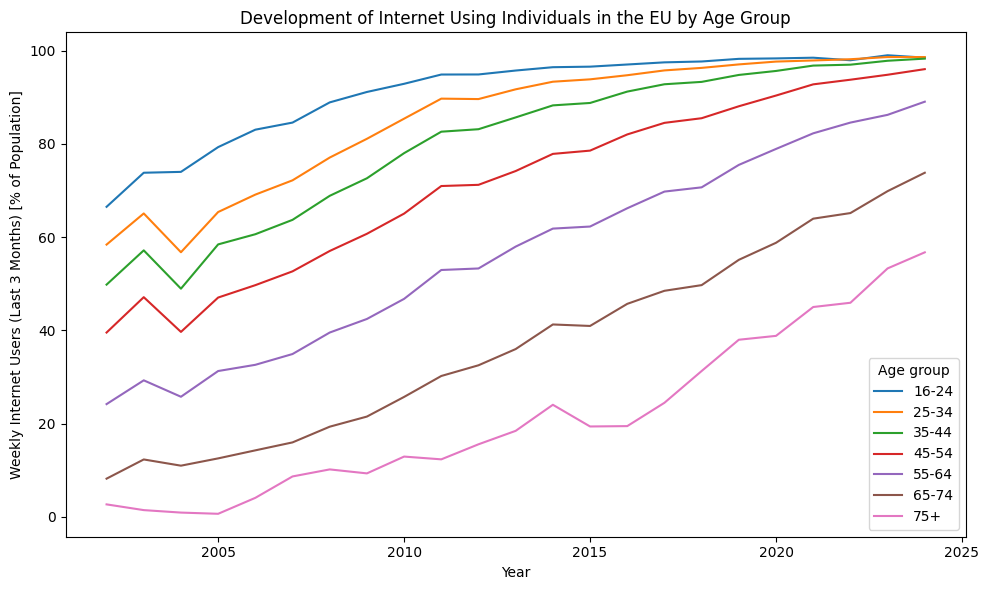

In [47]:
df_age = (
    df_plot
    .groupby(["TIME_PERIOD", "age_group"], as_index=False)[indicator]
    .mean()
)

plt.figure(figsize=(10,6))
sns.lineplot(
    data=df_age,
    x="TIME_PERIOD",
    y=indicator,
    hue="age_group"
)

plt.title("Development of Internet Using Individuals in the EU by Age Group")
plt.ylabel("Weekly Internet Users (Last 3 Months) [% of Population]")
plt.xlabel("Year")
plt.legend(title="Age group")
plt.tight_layout()
plt.show()


We created a line plot where each line represents a specific age bracket. The x-axis shows the timeline from 2002 to 2024, and the y-axis shows the EU average percentage of that groups individuals using the internet weekly. By using a single chart for all groups, we can immediately see the distance between generations and how that distance has changed over nearly two decades
The lines for the 16–24, 25–34, and 35-44 age groups are effectively at the top of the chart. They reached near 100% saturation very early on and have stayed there.
The lines for the older age groups with 55+ we see an clear increase in internet usage but there are still many individuals not using the internet weekly. Especially for the 75+ age group, we can see that only approximatly half of the individuals having an weekly internt usage.
In general we can clearly see that the younger the individuals the more of them uses the internt weekly.

One strange thing we noticed was the data shift around 2004. We found that this dip or change in the line wasn't because people stopped using the internet, but because the EU expanded in 2004 to include 10 new countries. Adding these new nations changed the EU Average rapidly. We decided to keep this in the plot to show the real history of the dataset, rather than trying to smooth it out artificially.

**1.2. Gender differences over time**

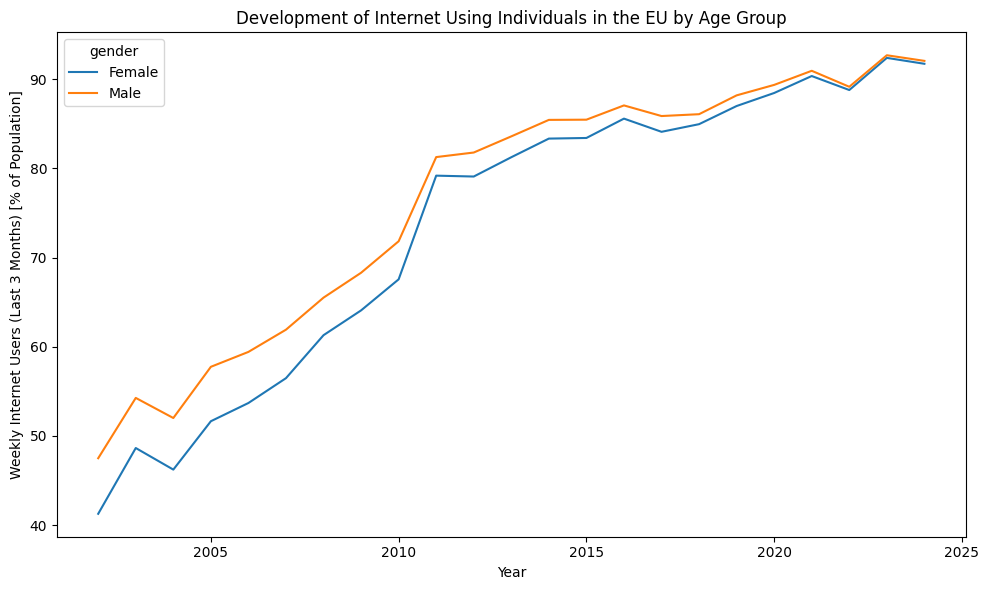

In [48]:
df_gender = (
    df
    .groupby(["TIME_PERIOD", "gender"], as_index=False)[indicator]
    .mean()
)

plt.figure(figsize=(10,6))
sns.lineplot(
    data=df_gender,
    x="TIME_PERIOD",
    y=indicator,
    hue="gender"
)

plt.title("Development of Internet Using Individuals in the EU by Age Group")
plt.ylabel("Weekly Internet Users (Last 3 Months) [% of Population]")
plt.xlabel("Year")
plt.tight_layout()
plt.show()


For our second analysis of research question 1, we wanted to see if men and women across the EU use the internet at different rates. While age was a very strong divider, we wanted to test if gender still plays a role in digital access. Again, we used the I_IU3_all indicator to measure weekly internet usage.
This visualization is a line plot comparing two categories "Men and Women". The x-axis tracks the timeline from 2002 to 2024, and the y-axis shows the EU average percentage of weekly usage. What stands out immediately compared to our age-group plot is how close these two lines are. Instead of a spread out of lines, we see two parallel paths that are slowly merging into one.
In the early 2000s, there was a visible "Gender Gap," with men using the internet at a higher rate. However, as we move toward the present day, the gap becomes almost invisible. This tells us that the barriers that might have existed for women in the early days of the internet have largely been dismantled.
In a modern EU business context, this means that digital marketing or services no longer need to worry about reaching women as a specific hurdle.

**1.3. Internt Usage by countries in 2024**

/tmp/ipykernel_16452/1327120618.py:7: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  idx = df_clean.groupby(['geo'])['TIME_PERIOD'].transform(max) == df_clean['TIME_PERIOD']


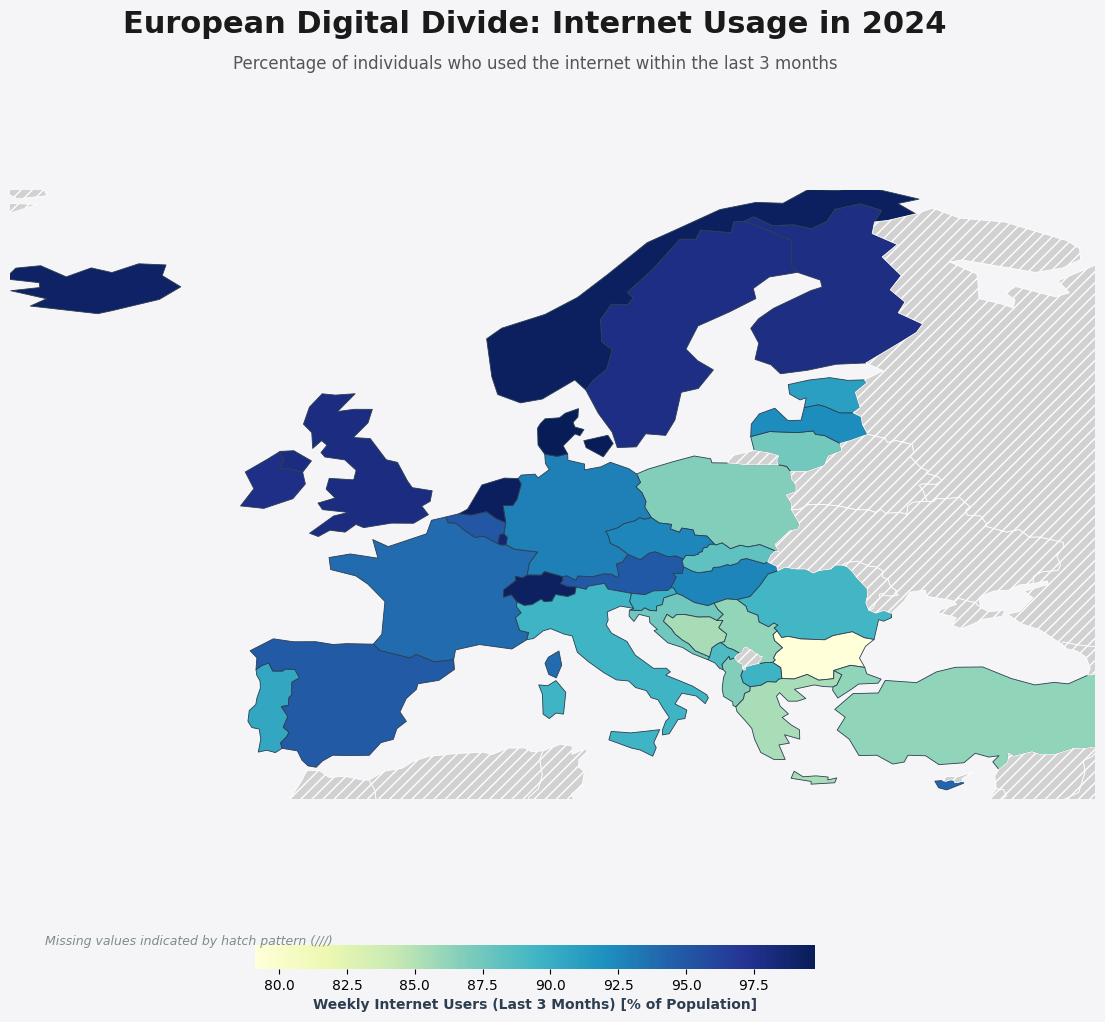

In [49]:
world_file = os.path.join(inputs_dir, "world-shapefile","ne_110m_admin_0_countries.shp")
world = gpd.read_file(world_file)
world.loc[world['NAME'] == 'France', 'ISO_A3'] = 'FRA'
world.loc[world['NAME'] == 'Norway', 'ISO_A3'] = 'NOR'

df_clean = df.dropna(subset=[indicator, "TIME_PERIOD"])
idx = df_clean.groupby(['geo'])['TIME_PERIOD'].transform(max) == df_clean['TIME_PERIOD']
df_map_data = df_clean[idx].groupby("geo")[indicator].mean().reset_index()

eurostat_to_iso3 = {
    'AL': 'ALB', 'AT': 'AUT', 'BA': 'BIH', 'BE': 'BEL', 'BG': 'BGR', 'CH': 'CHE',
    'CY': 'CYP', 'CZ': 'CZE', 'DE': 'DEU', 'DK': 'DNK', 'EE': 'EST', 'EL': 'GRC',
    'ES': 'ESP', 'FI': 'FIN', 'FR': 'FRA', 'HR': 'HRV', 'HU': 'HUN', 'IE': 'IRL',
    'IS': 'ISL', 'IT': 'ITA', 'LT': 'LTU', 'LU': 'LUX', 'LV': 'LVA', 'ME': 'MNE',
    'MK': 'MKD', 'MT': 'MLT', 'NL': 'NLD', 'NO': 'NOR', 'PL': 'POL', 'PT': 'PRT',
    'RO': 'ROU', 'RS': 'SRB', 'SE': 'SWE', 'SI': 'SVN', 'SK': 'SVK', 'TR': 'TUR',
    'UK': 'GBR', 'XK': 'XKX'
}
df_map_data['iso_code'] = df_map_data['geo'].map(eurostat_to_iso3)
merged = world.merge(df_map_data, left_on="ISO_A3", right_on="iso_code", how="left")


fig, ax = plt.subplots(1, 1, figsize=(14, 12), facecolor='#f5f5f7')

ax.set_xlim([-24, 42])
ax.set_ylim([34, 71])


plot = merged.plot(
    column=indicator,
    ax=ax,
    legend=False,
    cmap='YlGnBu',
    missing_kwds={"color": "#d1d1d1", "edgecolor": "#ffffff", "hatch": "///"},
    edgecolor='#2c3e50',
    linewidth=0.6,
    antialiased=True
)


sm_ = plt.cm.ScalarMappable(cmap='YlGnBu', norm=plt.Normalize(vmin=merged[indicator].min(), vmax=merged[indicator].max()))
cax = fig.add_axes([0.3, 0.1, 0.4, 0.02])
cb = fig.colorbar(sm_, cax=cax, orientation='horizontal')
cb.set_label('Weekly Internet Users (Last 3 Months) [% of Population]', fontsize=10, fontweight='bold', color='#2c3e50')
cb.outline.set_visible(False)


ax.set_facecolor('#e3f2fd')

plt.figtext(0.5, 0.88, "European Digital Divide: Internet Usage in 2024",
            ha='center', fontsize=22, fontweight='bold', color='#1a1a1a')
plt.figtext(0.5, 0.85, "Percentage of individuals who used the internet within the last 3 months",
            ha='center', fontsize=12, fontweight='regular', color='#555555')

plt.figtext(0.15, 0.12, "Missing values indicated by hatch pattern (///)",
            ha='left', fontsize=9, color='#7f8c8d', fontstyle='italic')


ax.set_axis_off()
plt.show()

After analyzing how age and gender influence internet usage, we wanted to see how these trends look across the European map. This geographical view helps us understand if "being in the EU" means the same thing for everyone, or if your physical location still determines your digital life. We used the most recent data available (2024) to create a snapshot of the current European landscape.
We created a Choropleth Map, where Dark Blue represents countries with very high weekly internet usage and Light Yellow represents countries where usage is lower.
The map reveals a clear "North-West vs. South-East" pattern that is common in European economic studies:


*   The darkest blue areas are concentrated in Northern Europe (countries like Norway, Finland, Denmark) and the Benelux region (Netherlands, Luxembourg). In these nations, weekly internet use is nearly universal. For a business, these are mature digital markets where almost every citizen can be reached online.
*   As we move toward the South and East (countries like Bulgaria, Romania, or Greece), the colors shift toward lighter greens and yellows. While usage is still high by global standards, it hasn't reached the saturation point seen in the North. This suggests that the digital divide isn't just about age, it seems like it’s also about national infrastructure and economic development.




**Q2: Does higher broadband internet coverage speed imply higher frequency of internet usage?**

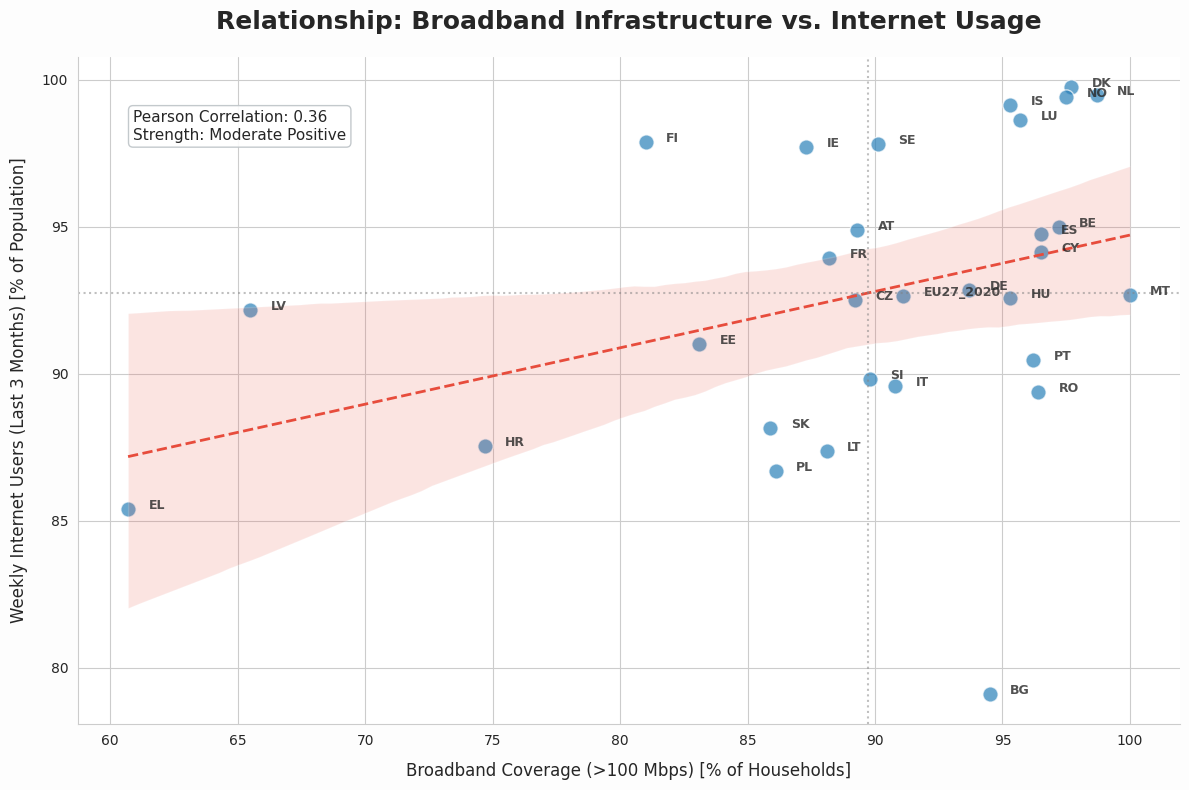

In [50]:

df_q2 = q2_df.copy()

latest_year = df_q2['TIME_PERIOD'].max()
df_2024 = df_q2[df_q2['TIME_PERIOD'] == latest_year].copy()


df_country = df_2024.groupby('geo').agg({
    'MBPS_GT100': 'mean',
    'I_IU3_all': 'mean'
}).dropna().reset_index()


correlation = df_country['MBPS_GT100'].corr(df_country['I_IU3_all'])


plt.figure(figsize=(12, 8), facecolor='#fdfdfd')

sns.set_style("whitegrid")
scatter = sns.regplot(
    data=df_country, x='MBPS_GT100', y='I_IU3_all',
    scatter_kws={'s': 120, 'alpha': 0.7, 'color': '#2980b9', 'edgecolor': 'white'},
    line_kws={'color': '#e74c3c', 'lw': 2, 'ls': '--'}
)


for i in range(df_country.shape[0]):
    plt.text(
        df_country.MBPS_GT100[i] + 0.8,
        df_country.I_IU3_all[i],
        df_country.geo[i],
        fontsize=9, weight='semibold', alpha=0.8
    )


plt.title("Relationship: Broadband Infrastructure vs. Internet Usage", fontsize=18, pad=20, weight='bold')
plt.xlabel("Broadband Coverage (>100 Mbps) [% of Households]", fontsize=12, labelpad=10)
plt.ylabel("Weekly Internet Users (Last 3 Months) [% of Population]", fontsize=12, labelpad=10)


stats_text = f'Pearson Correlation: {correlation:.2f}\nStrength: Moderate Positive'
plt.gca().text(0.05, 0.92, stats_text, transform=plt.gca().transAxes,
               bbox=dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='#bdc3c7'),
               fontsize=11, verticalalignment='top')


plt.axvline(df_country['MBPS_GT100'].mean(), color='gray', linestyle=':', alpha=0.5)
plt.axhline(df_country['I_IU3_all'].mean(), color='gray', linestyle=':', alpha=0.5)

sns.despine()
plt.tight_layout()
plt.show()

For this research question, we wanted to see if the availability of high-speed internet (Broadband > 100 Mbps) acts as a driver for usage frequency in 2024.
We used a Regression Plot. Each dot is a country, plotted based on the two variables: the percentage of households with access to speeds over 100 Mbps and the percentage of the population using the internet weekly.
The dotted lines in the plot each represents the EU average.
We also included the Pearson Correlation coefficient to give a mathematical score to the relationship.

The red dashed line goes up to the right, and the correlation is 0.36. This means that, generally speaking, countries with better broadband do tend to have more frequent users.

While our regression line shows a positive correlation, outliers like Bulgaria prove that infrastructure is only half of the equation. This highlights a potential bias in our research question: we are measuring supply (broadband) but not affordability or digital literacy. This suggests that for some regions, the barrier to internet usage is no longer the speed of the connection, but rather the economic and educational ability of the population to use it.


            Correlation (r)
MBPS_GT30          0.160499
MBPS_GT100         0.361977
GBPS_GT1           0.495195


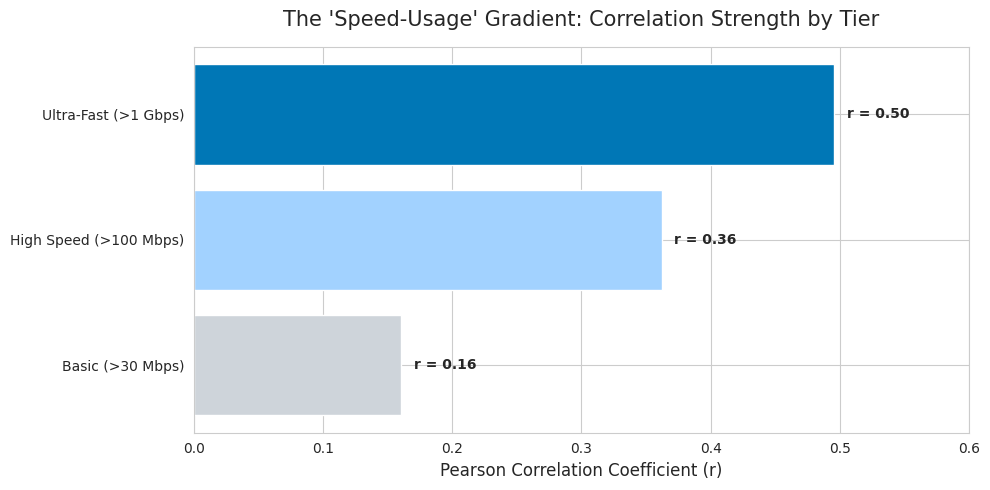

In [51]:
speed_vars = ['MBPS_GT30', 'MBPS_GT100', 'GBPS_GT1']
usage_var = 'I_IU3_all'


results = {}
for speed in speed_vars:
    temp_df = df_2024[['geo', speed, usage_var]].dropna()
    country_avg = temp_df.groupby('geo').mean()
    results[speed] = country_avg[speed].corr(country_avg[usage_var])


gen_results = pd.DataFrame.from_dict(results, orient='index', columns=['Correlation (r)'])
print(gen_results)

results = pd.DataFrame({
    'Tier': ['Basic (>30 Mbps)', 'High Speed (>100 Mbps)', 'Ultra-Fast (>1 Gbps)'],
    'Correlation': [0.160499, 0.361977, 0.495195]
})

plt.figure(figsize=(10, 5))
colors = ['#ced4da', '#a2d2ff', '#0077b6']
bars = plt.barh(results['Tier'], results['Correlation'], color=colors)

plt.xlim(0, 0.6)
plt.title("The 'Speed-Usage' Gradient: Correlation Strength by Tier", fontsize=15, pad=15)
plt.xlabel("Pearson Correlation Coefficient (r)", fontsize=12)


for bar in bars:
    plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2,
             f'r = {bar.get_width():.2f}', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

For the next step in Research Question 2, we wanted to see if the intensity of broadband coverage changes its impact on usage. We tested three different speed tiers:


*   Basic (>30 Mbps)
*   High Speed (>100 Mbps)
*   Ultra-Fast (>1 Gbps)

By calculating the correlation coefficient (r) for each tier separately, we can see which type of infrastructure is the most powerful magnet for getting people online.

The correlation for >30 Mbps is very low (r = 0.16). This tells us that simply having basic broadband doesn't strongly predict if a population will use the internet frequently. In 2024, 30 Mbps is considered the bare minimum, and its presence alone doesn't drive new behavior.

The correlation jumps significantly (r = 0.36) when we move to the 100 Mbps tier. This suggests that High Speed is where the internet becomes useful enough for modern life, which in turn drives more frequent usage.

The highest correlation (r = 0.50) is found in the >1 Gbps tier. It seems countries that invest in the best infrastructure see the strongest link to high usage rates. This might be because Gigabit speeds enable entirely new types of digital behavior that keep people online more often or that building ultra fast pipes is just worth it in countries with a already high internt usage.

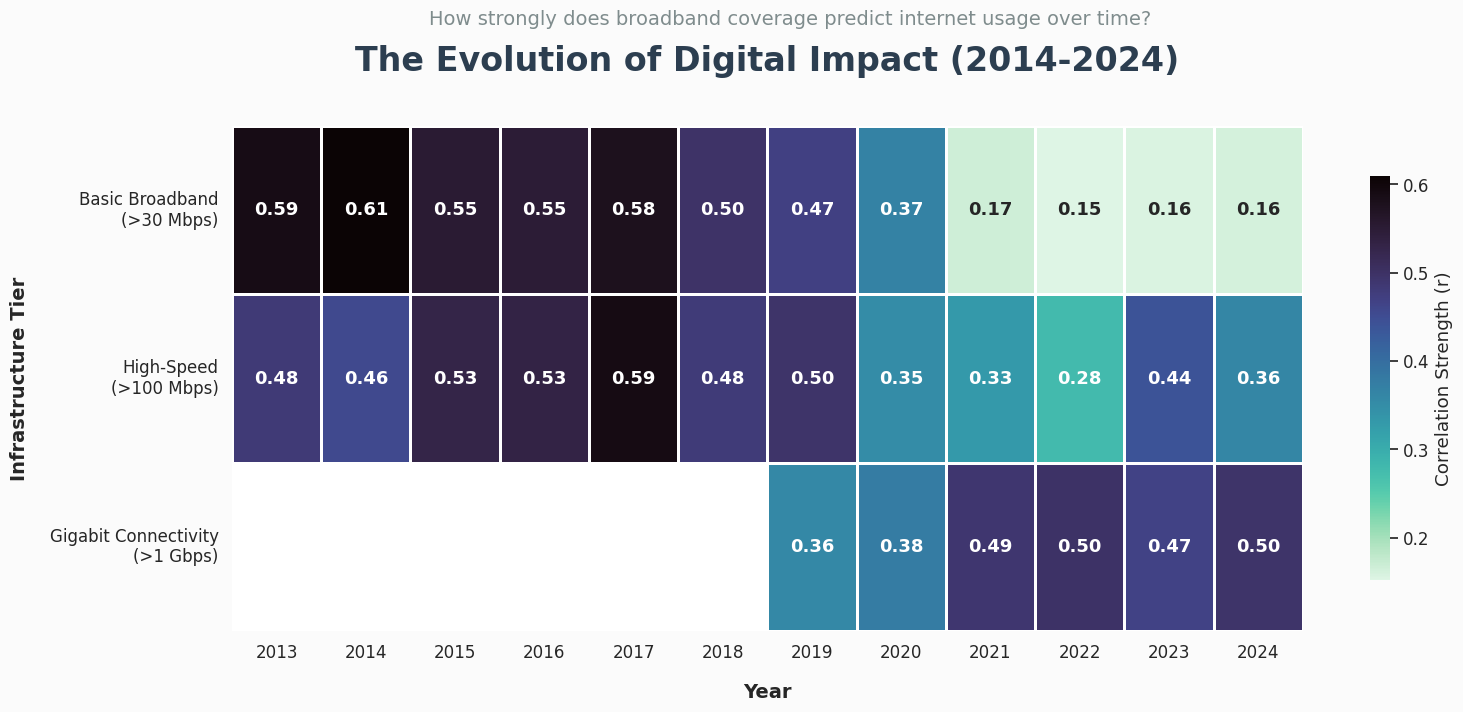

In [52]:
df = q2_df.copy()
speed_vars = ['MBPS_GT30', 'MBPS_GT100', 'GBPS_GT1']
usage_var = 'I_IU3_all'


df_agg = df.groupby(['geo', 'TIME_PERIOD'])[[usage_var] + speed_vars].mean().reset_index()


years = sorted(df_agg['TIME_PERIOD'].unique())
corr_results = []

for year in years:
    year_data = df_agg[df_agg['TIME_PERIOD'] == year]
    year_corrs = {'Year': year}
    for speed in speed_vars:
        valid = year_data[[speed, usage_var]].dropna()
        if len(valid) >= 5:
            year_corrs[speed] = valid[speed].corr(valid[usage_var])
        else:
            year_corrs[speed] = None
    corr_results.append(year_corrs)


corr_matrix = pd.DataFrame(corr_results).set_index('Year').T

plt.figure(figsize=(16, 8), facecolor='#fbfbfb')
sns.set_theme(style="white", font_scale=1.1)


cmap = sns.color_palette("mako_r", as_cmap=True)

ax = sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap=cmap,
    linewidths=2,
    linecolor='white',
    cbar_kws={"shrink": .8, "label": "Correlation Strength (r)"},
    annot_kws={"size": 13, "weight": "bold"}
)


ax.set_yticklabels(['Basic Broadband\n(>30 Mbps)', 'High-Speed\n(>100 Mbps)', 'Gigabit Connectivity\n(>1 Gbps)'],
                   rotation=0, fontsize=12, fontweight='medium')

plt.title("The Evolution of Digital Impact (2014-2024)",
          fontsize=24, fontweight='bold', pad=40, loc='center', color='#2c3e50')
plt.suptitle("How strongly does broadband coverage predict internet usage over time?",
             fontsize=14, color='#7f8c8d', y=0.92)

plt.xlabel("Year", fontsize=14, labelpad=15, fontweight='bold')
plt.ylabel("Infrastructure Tier", fontsize=14, labelpad=15, fontweight='bold')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In this final step we want to ask how this correlation has cahnged over time.

In 2014, there was still a moderate correlation for 30 Mbps. However, over the years, these values have faded. This tells us that today, a 30 Mbps connection is such a basic standard that it no longer serves as a differentiator for whether someone is an active internet user or not.

The middle row (>100 Mbps) shows a stable, moderate correlation. This appears to be the current baseline for the European digital society.

If you look at the bottom row, the correlation for Gigabit speeds has grown significantly darker and stronger over time. Gigabite connections seem to have replaced the other tiers as strongest predctores since 2021.

**Q3: Does higher internet use frequency imply more mobile broadband internet traffic within or outside of the country?**

For our third research question, we wanted to see if people who use the internet more frequently also consume more mobile data. We split this into two parts: Internal Data (usage within their home country) and Roaming Data (usage while traveling outside their country). This helps us understand if a digital lifestyle travels with the user or if it's mostly tied to their home environment.

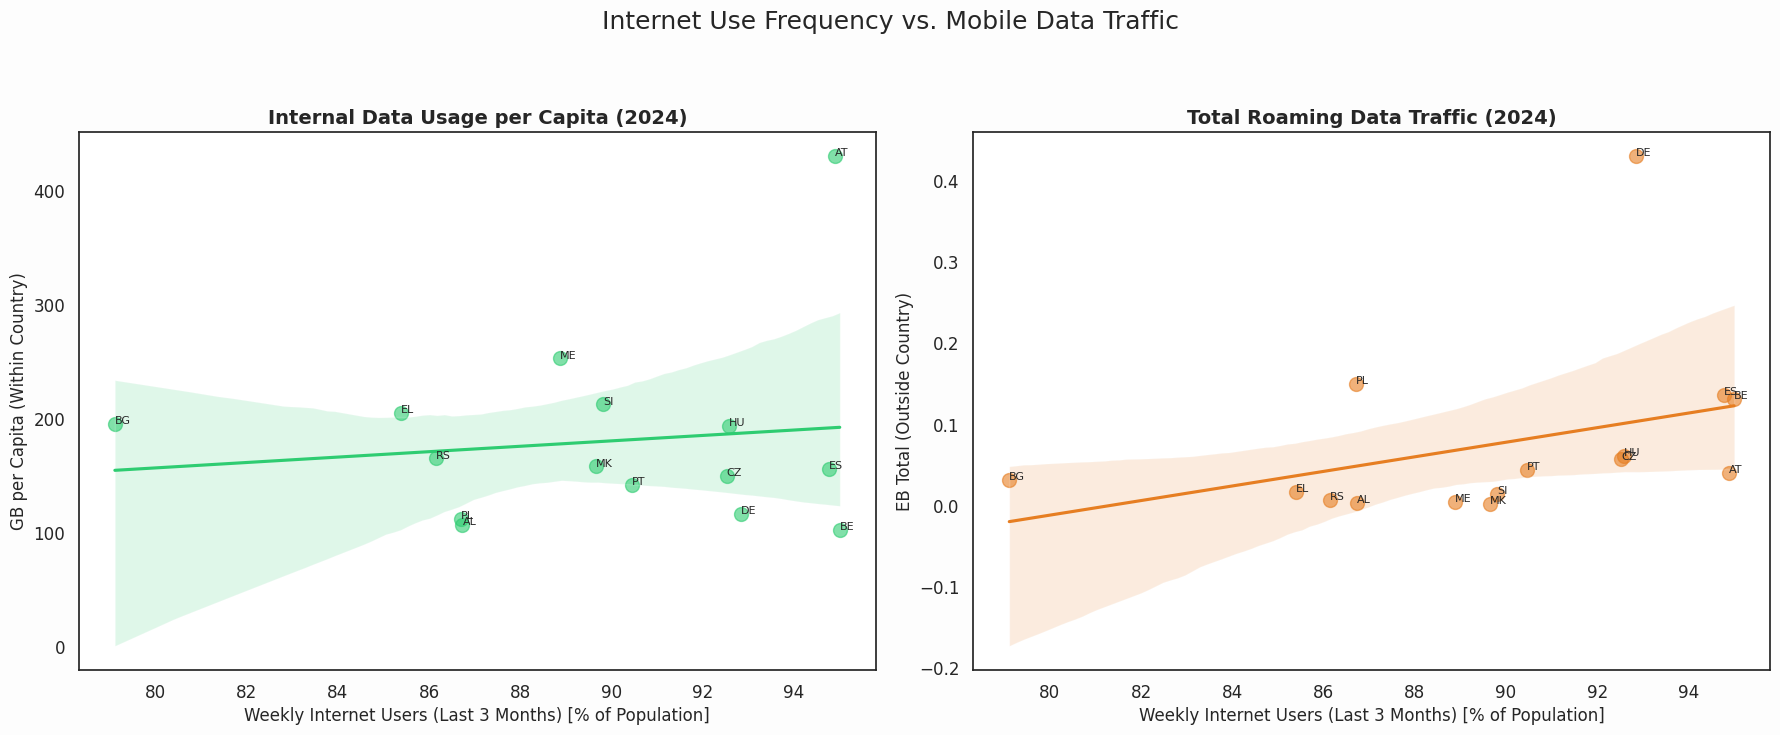

Correlation (Within Country): 0.13
Correlation (Outside/Roaming): 0.36


In [53]:
latest_year = q3_df['TIME_PERIOD'].max()
df_q3_latest = q3_df[q3_df['TIME_PERIOD'] == latest_year].copy()

df_country_q3 = df_q3_latest.groupby('geo').agg({
    'I_IU3_all': 'mean',
    'GB_per_cap_within': 'mean',
    'EB_Total_outside': 'mean'
}).dropna().reset_index()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7), facecolor='#fdfdfd')

sns.regplot(data=df_country_q3, x='I_IU3_all', y='GB_per_cap_within',
            ax=ax1, color='#2ecc71', scatter_kws={'s':100, 'alpha':0.6})
ax1.set_title(f"Internal Data Usage per Capita ({latest_year})", fontsize=14, fontweight='bold')
ax1.set_xlabel("Weekly Internet Users (Last 3 Months) [% of Population]", fontsize=12)
ax1.set_ylabel("GB per Capita (Within Country)", fontsize=12)

sns.regplot(data=df_country_q3, x='I_IU3_all', y='EB_Total_outside',
            ax=ax2, color='#e67e22', scatter_kws={'s':100, 'alpha':0.6})
ax2.set_title(f"Total Roaming Data Traffic ({latest_year})", fontsize=14, fontweight='bold')
ax2.set_xlabel("Weekly Internet Users (Last 3 Months) [% of Population]", fontsize=12)
ax2.set_ylabel("EB Total (Outside Country)", fontsize=12)

for i in range(df_country_q3.shape[0]):
    ax1.text(df_country_q3.I_IU3_all[i], df_country_q3.GB_per_cap_within[i], df_country_q3.geo[i], fontsize=8)
    ax2.text(df_country_q3.I_IU3_all[i], df_country_q3.EB_Total_outside[i], df_country_q3.geo[i], fontsize=8)

plt.suptitle("Internet Use Frequency vs. Mobile Data Traffic", fontsize=18, y=1.05)
plt.tight_layout()
plt.show()

corr_within = df_country_q3['I_IU3_all'].corr(df_country_q3['GB_per_cap_within'])
corr_outside = df_country_q3['I_IU3_all'].corr(df_country_q3['EB_Total_outside'])

print(f"Correlation (Within Country): {corr_within:.2f}")
print(f"Correlation (Outside/Roaming): {corr_outside:.2f}")

We created a side-by-side comparison using two regression plots.

The Green Plot shows the relationship between internt usage and data used per capita within the country. To measure the data usage within the county we use the GB per Capita indicator, which takes the total amount of mobile data consumed by everyone in the country and divides it by the total number of people.

The Orange Plot shows the relationship between internt usage and total roaming traffic. To measure this, we used the EB Total Outside indicator. This is a macro measure that tracks the total volume of data (in Exabytes) consumed by all citizens of a country while they are traveling abroad. Because this is a national total rather than a per-person average, it helps us see the overall 'digital footprint' a country leaves while roaming.

Both plots use 2024 data and include a regression line to show the general trend. We also labeled the individual dots with country codes to spot any specific outliers. Here we can also see that way less countries have reported these metrics, making it less reliable.

We found an extremely weak correlation between how often people go online and how much data they use at home. This suggests that being an internet user doesn't automatically mean you are a heavy data consumer. A person might check their email every day but never stream 4K video. Furthermore, in many countries, people use Wi-Fi at home, which means their mobile data consumption stays low even if they are online.

Interestingly, the correlation is nearly three times stronger for roaming data. This suggests that people who are frequent internet users at home are more likely to maintain those habits while traveling.


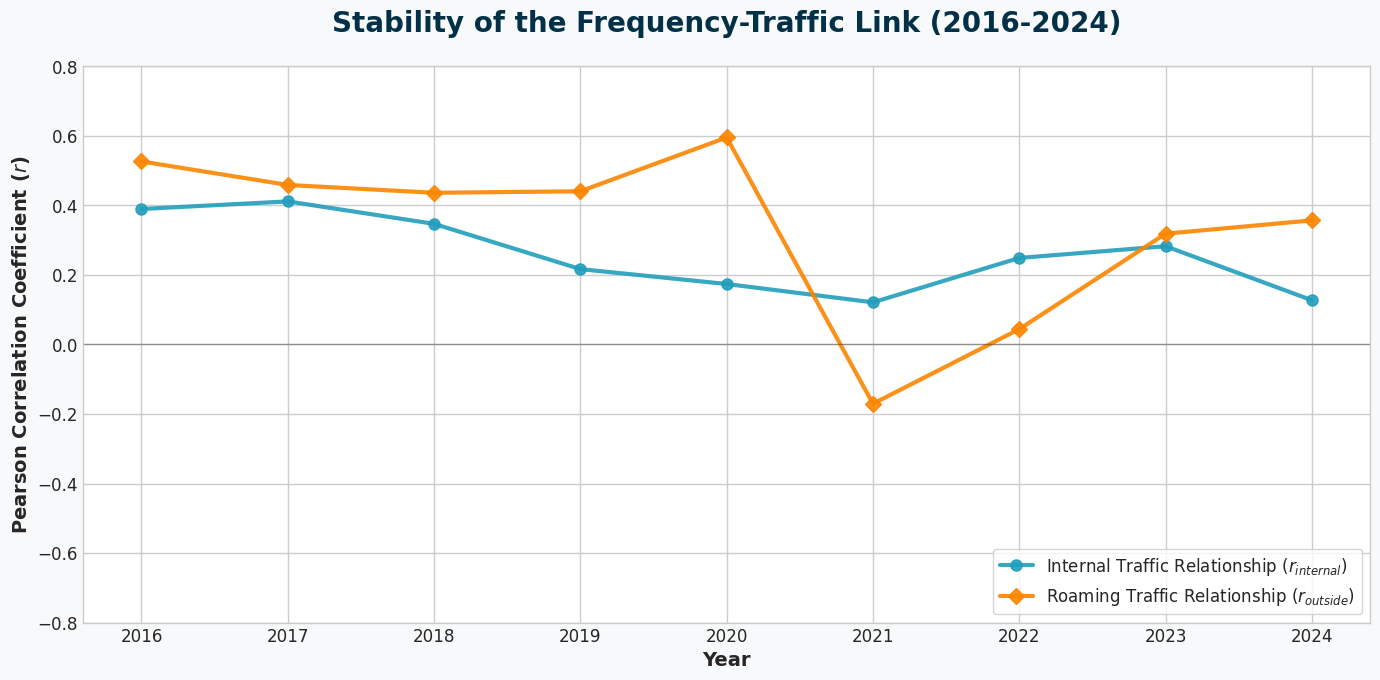

In [54]:
df = q3_df.copy()

years = sorted([y for y in df['TIME_PERIOD'].unique() if y >= 2016])
results = []

for year in years:
    year_data = df[df['TIME_PERIOD'] == year]

    year_grouped = year_data.groupby('geo').agg({
        'I_IU3_all': 'mean',
        'GB_per_cap_within': 'mean',
        'EB_Total_outside': 'mean'
    }).dropna()

    if len(year_grouped) > 5:
        r_in = year_grouped['I_IU3_all'].corr(year_grouped['GB_per_cap_within'])
        r_out = year_grouped['I_IU3_all'].corr(year_grouped['EB_Total_outside'])
    else:
        r_in, r_out = None, None

    results.append({'Year': int(year), 'Internal_r': r_in, 'Outside_r': r_out})

results_df = pd.DataFrame(results)
results_df.to_csv('q3_correlation_time_series.csv', index=False)

plt.figure(figsize=(14, 7), facecolor='#f8f9fa')
plt.style.use('seaborn-v0_8-whitegrid')

plt.plot(results_df['Year'], results_df['Internal_r'],
         marker='o', markersize=8, color='#219ebc',
         linewidth=3, label='Internal Traffic Relationship ($r_{internal}$)',
         alpha=0.9)

plt.plot(results_df['Year'], results_df['Outside_r'],
         marker='D', markersize=8, color='#fb8500',
         linewidth=3, label='Roaming Traffic Relationship ($r_{outside}$)',
         alpha=0.9)

plt.ylim(-0.8, 0.8)
plt.axhline(0, color='black', linewidth=1, alpha=0.3)


plt.title("Stability of the Frequency-Traffic Link (2016-2024)",
          fontsize=20, fontweight='bold', pad=25, color='#023047')
plt.xlabel("Year", fontsize=14, fontweight='bold')
plt.ylabel("Pearson Correlation Coefficient ($r$)", fontsize=14, fontweight='bold')

plt.legend(frameon=True, fontsize=12, loc='lower right', facecolor='white')
plt.xticks(results_df['Year'])
plt.tight_layout()

plt.savefig('q3_line_plot_professional.png', dpi=300)
plt.show()

We created a double line plot showing the Pearson Correlation Coefficient (r) for every year from 2014 to 2024.The Blue Line represents the relationship between internt usage and GB per capita.The Orange Line represents the relationship between internt usage and roaming data.

The correlation for roaming traffic remains consistently higher than internal traffic for nearly the entire decade. This suggests that Frequent Internet Users are primary drivers of cross border data traffic.

The correlation for internal traffic remains relatively weak and flat. This reinforces our earlier observation that domestic mobile data consumption is likely governed by factors other than just frequency.

In 2021 and 2022, the visualization shows a notable decrease in the roaming traffic correlation. This shift is likely due to the COVID pandemic, during which international travel was highly restricted. With fewer people traveling, the usual relationship between frequent internet users and roaming data volume was disrupted, as even the most active users were forced to stay within their home countries.

**Q4: Do countries with higher internet access also show higher digital skill levels?**
Will be answered for the time range between 2015 and 2019

Before analyzing the relationship between infrastructure and human capability, we must define the proxies used for Internet Access and Digital Skills.

To measure access, we use the percentage of households with internet access at home.

To measure skills, we use the percentage of individuals with above basic digital skills.

For this specific question, we do not look at the raw percentages. Instead, we calculate the Percentage Point Change between 2015 and 2019. We do this since if we only looked at raw numbers, the correlation would be misleadingly high because wealthy countries are usually good at both. By looking at the Growth, we are testing a causal like relationship. (e.g. If a country's access grew by 10%, did its skills also grow by 10%?)

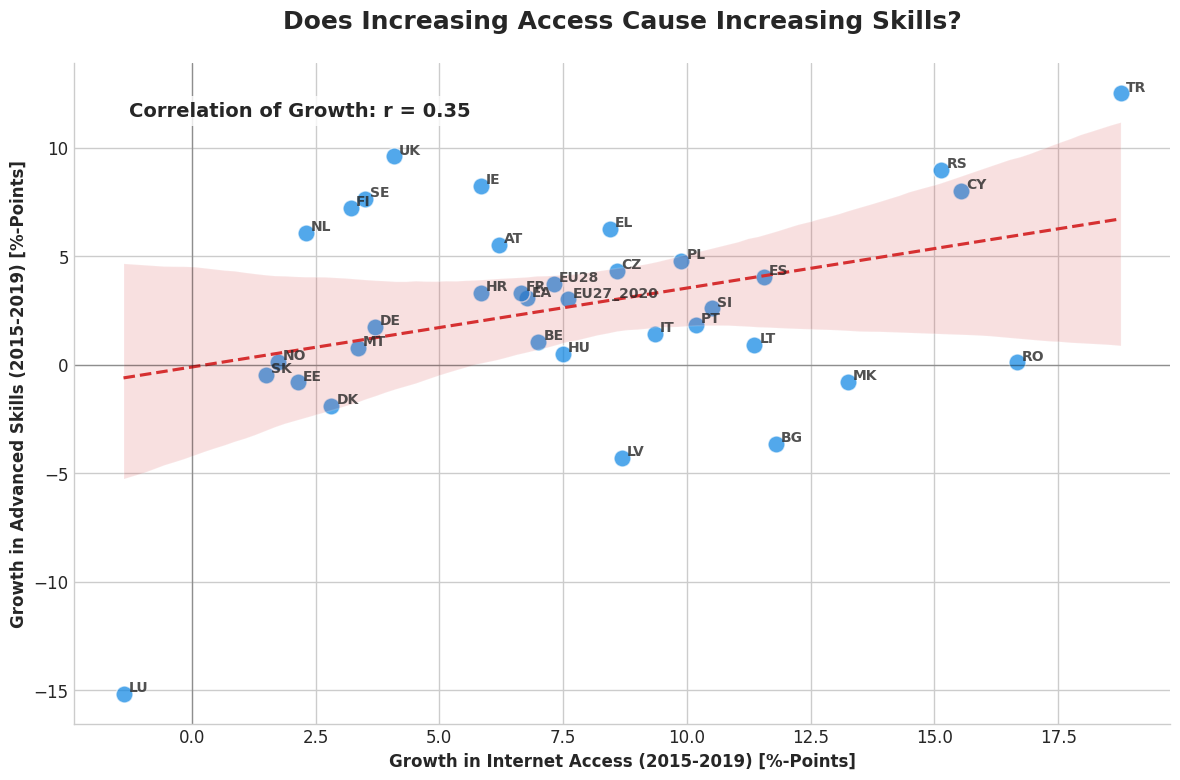

In [55]:
df_q4 = q4_df[q4_df['TIME_PERIOD'].isin([2015, 2019])].copy()


df_q4['OBS_VALUE'] = pd.to_numeric(df_q4['OBS_VALUE'], errors='coerce').astype(float)
df_q4['I_DSK_AB'] = pd.to_numeric(df_q4['I_DSK_AB'], errors='coerce').astype(float)


df_clean = df_q4.groupby(['geo', 'TIME_PERIOD'])[['OBS_VALUE', 'I_DSK_AB']].mean().reset_index()

growth_df = df_clean.pivot(index='geo', columns='TIME_PERIOD', values=['OBS_VALUE', 'I_DSK_AB'])
growth_df.columns = ['Access_2015', 'Access_2019', 'Skills_2015', 'Skills_2019']

growth_df['Access_Increase'] = growth_df['Access_2019'] - growth_df['Access_2015']
growth_df['Skill_Increase'] = growth_df['Skills_2019'] - growth_df['Skills_2015']
growth_df = growth_df.dropna()

plt.figure(figsize=(12, 8), facecolor='white')
sns.set_style("whitegrid")

sns.regplot(data=growth_df, x='Access_Increase', y='Skill_Increase',
            scatter_kws={'s':150, 'color':'#0984e3', 'edgecolor':'w', 'alpha':0.7},
            line_kws={'color':'#d63031', 'linestyle':'--'})

for geo, row in growth_df.iterrows():
    plt.text(row['Access_Increase'] + 0.1, row['Skill_Increase'] + 0.1, geo,
             fontsize=10, fontweight='bold', alpha=0.8)

plt.title("Does Increasing Access Cause Increasing Skills?", fontsize=18, fontweight='bold', pad=25)
plt.xlabel("Growth in Internet Access (2015-2019) [%-Points]", fontsize=12, fontweight='bold')
plt.ylabel("Growth in Advanced Skills (2015-2019) [%-Points]", fontsize=12, fontweight='bold')

plt.axhline(0, color='black', linewidth=1, alpha=0.3)
plt.axvline(0, color='black', linewidth=1, alpha=0.3)

r_val = growth_df['Access_Increase'].corr(growth_df['Skill_Increase'])
plt.annotate(f"Correlation of Growth: r = {r_val:.2f}", xy=(0.05, 0.92),
             xycoords='axes fraction', fontsize=14, fontweight='bold',
             bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

sns.despine()
plt.tight_layout()
plt.show()

The plot shows a moderate positive relationship between the growth of access and the growth of advanced skills.
A correlation value of 0.35 suggests that there is a meaningful, though not guaranteed, connection. Countries that aggressively expanded household internet access generally saw a concurrent rise in the percentage of the population with above basic digital skills.

We can also observe a quite dominant outlier with Luxembourg as it has an decrease in Skills and no growth in internet access. This could be caused by the small population size in Luxembourg.

In [56]:

lu_2015 = q4_df[(q4_df['geo'] == 'LU') & (q4_df['TIME_PERIOD'] == 2015)]
lu_2019 = q4_df[(q4_df['geo'] == 'LU') & (q4_df['TIME_PERIOD'] == 2019)]

access_val = lu_2015['OBS_VALUE'].values[0]
skills_val = lu_2015['I_DSK_AB'].values[0]

print(f"Luxembourg 2015 - Internet Access: {access_val}%")
print(f"Luxembourg 2015 - Advanced Skills: {skills_val}%")

access_val_19 = lu_2019['OBS_VALUE'].values[0]
skills_val_19 = lu_2019['I_DSK_AB'].values[0]

print(f"Luxembourg 2019 - Internet Access: {access_val_19}%")
print(f"Luxembourg 2019 - Advanced Skills: {skills_val_19}%")

Luxembourg 2015 - Internet Access: 92.02%
Luxembourg 2015 - Advanced Skills: 54.64%
Luxembourg 2019 - Internet Access: 89.32%
Luxembourg 2019 - Advanced Skills: 38.730000000000004%


## 4. Predictive models

4.1. Q1: What is the development of internet use frequency among individuals in EU countries (depending on age, gender, education, employment, nationality)?
Will be answered for the time range between 2002 and 2024

Dataset structure: the dataset contains multiple observation values for the target variable, internet use frequency, because it does not provide complete rows for all demographic features but only selected combinations of them. As a result, fitting a predictive model directly is challenging. Introducing an explicit “missing” category for each demographic variable would simplify the modeling task. The models considered for this research question are pooled OLS estimation and an autoregressive AR(2) model for forecasting.

Some functions for the models are defined below. These are

- filter_reliable_rows: uses reliable values for the target variable I_IU3_all
- select_features: chosen as explanatory variables
- drop_missing_target: omits rows without target
- add_lags: creates lagged values for AR(2) model
- clean_categoricals: missing values are labeled as 'Missing' and they count as category.

4.1.1 Pooled OLS for Q1

In [57]:
def filter_reliable_rows(df):
    """Remove rows with low-reliability OBS_FLAG_ indicators."""
    flag_cols = [c for c in df.columns if c.startswith("OBS_FLAG_")]
    if not flag_cols:
        return df.copy()

    mask_low = df[flag_cols].apply(
        lambda row: row.dropna().astype(str).str.contains("u").any(),
        axis=1
    )
    return df.loc[~mask_low].reset_index(drop=True)


def select_features(df, target_col):
    feature_cols = [
        c for c in df.columns
        if not (c.startswith("OBS") or c.startswith("I_"))
    ]
    return df[feature_cols + [target_col]].copy()


def drop_missing_target(df, target_col):
    """Drop rows with missing outcome."""
    return df[df[target_col].notna()].copy()

# for the AR(2) model
def add_lags(df, target_col, lags=(1, 2), group_col="geo", time_col="TIME_PERIOD"):
    df = df.sort_values([group_col, time_col]).copy()
    for lag in lags:
        df[f"{target_col}_lag{lag}"] = (
            df.groupby(group_col)[target_col].shift(lag)
        )
    return df


def clean_categoricals(df, categorical_cols):
    """Replace structural missingness in categoricals with 'Missing'."""
    df = df.copy()
    for col in categorical_cols:
        if col in df.columns:
            df[col] = (
                df[col]
                .astype(object)
                .where(df[col].notna(), "Missing")
            )
    return df

Data preparation specific to this technique:

In [58]:
target_col = "I_IU3_all"
categorical_cols = [
    'geo', 'gender', 'age_group', 'nativity',
    'nationality', 'disability', 'education', 'hh_income'
]

df = filter_reliable_rows(q1_df)
df = select_features(df, target_col)
df = drop_missing_target(df, target_col)
df = clean_categoricals(df, categorical_cols)

# reference categories
reference_levels = {
    "geo": "EU28",
    "gender": "Female",
    "age_group": "16-74",  
    "nativity": "Missing",
    "nationality": "Missing",
    "disability": "Missing",
    "education": "Missing",
    "hh_income": "Missing",
}

for col, ref in reference_levels.items():
    if col in df.columns:
        levels = list(df[col].dropna().unique())
        if ref in levels:
            ordered_levels = [ref] + [l for l in levels if l != ref]
            df[col] = pd.Categorical(df[col], categories=ordered_levels, ordered=True)
        else:
            raise ValueError(f"Reference '{ref}' not found in {col}: {levels}")

# design matrix
X = df.drop(columns=[target_col])
y = df[target_col].astype(float)

X_dum = pd.get_dummies(
    X,
    columns=[c for c in categorical_cols if c in X.columns],
    drop_first=True
)

reg_df = pd.concat([X_dum, y], axis=1)
reg_df = reg_df.replace([np.inf, -np.inf], np.nan).dropna()

X_clean = reg_df.drop(columns=[target_col]).astype(float)
y_clean = reg_df[target_col].astype(float)

# Pooled OLS fit
X_sm = sm.add_constant(X_clean)

ols_model_q1 = sm.OLS(
    y_clean,
    X_sm
).fit(
    cov_type="cluster",
    cov_kwds={"groups": df.loc[reg_df.index, "geo"]}
)

print(ols_model_q1.summary2().as_text())

                      Results: Ordinary least squares
Model:                  OLS                Adj. R-squared:       0.780      
Dependent Variable:     I_IU3_all          AIC:                  357823.7894
Date:                   2026-01-07 23:58   BIC:                  358498.4422
No. Observations:       47180              Log-Likelihood:       -1.7883e+05
Df Model:               76                 F-statistic:          1410.      
Df Residuals:           47103              Prob (F-statistic):   6.27e-56   
R-squared:              0.780              Scale:                114.98     
----------------------------------------------------------------------------
                    Coef.    Std.Err.     z     P>|z|    [0.025     0.975]  
----------------------------------------------------------------------------
const             -4145.2817 257.2641  -16.1129 0.0000 -4649.5101 -3641.0533
TIME_PERIOD           2.0954   0.1276   16.4188 0.0000     1.8452     2.3455
geo_AL              -1

/home/lucas/projects/exdex/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 76, but rank is 33
  warnings.warn('covariance of constraints does not have full '


Comments on pooled OLS results:

Reference categories are explicitly defined for all categorical variables to ensure clarity and avoid ambiguity in interpretation.

- Country effects. Negative coefficients for country categories indicate lower internet use frequency relative to the European reference trend, whereas positive coefficients indicate higher internet use compared to this benchmark.

- Age effects.The reference age category is 16–74. Negative coefficients therefore reflect lower internet use relative to this group. This pattern is particularly pronounced for older age groups, such as 55–64, 55–74, 65–74, and 75+, indicating substantially lower internet use among older cohorts. In contrast, younger age groups most notably 0–15 exhibit higher internet use relative to the reference category.

- Socio-demographic characteristics. For nativity, nationality, disability, education, and household income, the reference category is “Missing”, allowing for an assessment of whether the presence of these characteristics is associated with differences in internet use. Internet use increases when nativity and nationality are observed, while it decreases for individuals reporting moderate to severe disabilities. A similar negative pattern is observed for lower levels of education and low or medium household income, whereas higher education and higher income levels are associated with increased internet use frequency. Internet usage increases for male users relative to the reference gender category (female).

- All predictors are statistically highly significant (p < 0.0001) with the exception of the geo_EU27_2007, geo_EU25 and the “Missing” category for gender.

- The adjusted R squared value is 0.780.

4.1.1.2 Diagnostic plots of the pooled OLS

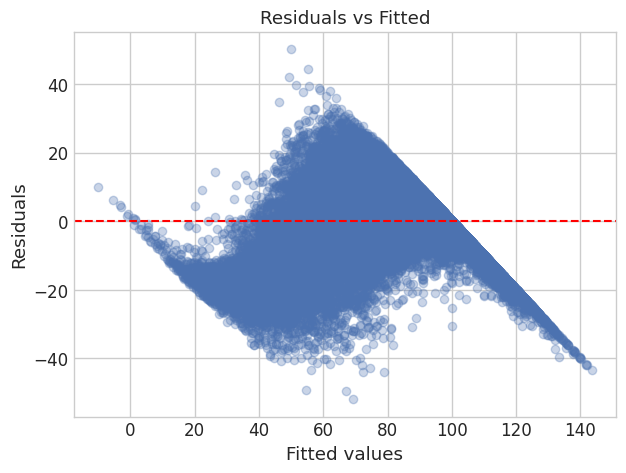

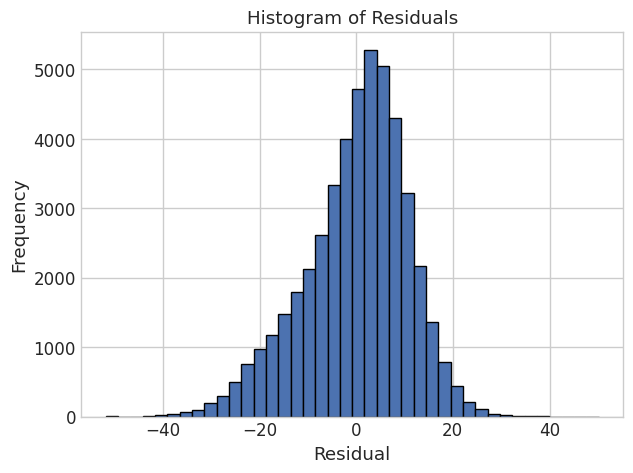

In [59]:
residuals = ols_model_q1.resid
fitted = ols_model_q1.fittedvalues

plt.figure(figsize=(7, 5))
plt.scatter(fitted, residuals, alpha=0.3)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted")
plt.show()
plt.figure(figsize=(7, 5))
plt.hist(residuals, bins=40, edgecolor="black")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.title("Histogram of Residuals")
plt.show()

The diagnostic plots indicate the presence of heteroskedasticity, suggesting a violation of one of the standard assumptions of linear regression models. This may result from the inclusion of numerous dummy variables, which can increase variability in the model.

4.1.2 Autoregressive AR(2) model
Helper functions for the autoregressive AR(2) model are defined below:

- fit_ar2_beta: OLS estimation of AR(2) coefficients.
- forecast_ar2: iterates forecasting from an AR(2) model.
- run_ar2_per_country: runs AR(2) for different countries and evaluates model performance for test data.

Moreover, we apply a logit transformation to ensure that model predictions are bounded within the interval (0, 1), which allows the results to be interpreted as percentages.

In [60]:
def fit_ar2_beta(series):
    """
    Fit AR(2): y_t = a + b1*y_{t-1} + b2*y_{t-2}
    Returns beta = [a, b1, b2]
    """
    s = np.asarray(series, dtype=float)

    # at least 3 observations
    if len(s) < 3:
        raise ValueError("Series too short for AR(2)")

    y = s[2:]
    X = np.column_stack([
        np.ones(len(y)),
        s[1:-1],
        s[:-2]
    ])

    # estimate parameters b1 and b2 using least squares
    beta, *_ = np.linalg.lstsq(X, y, rcond=None)
    return beta


def forecast_ar2(beta, history, steps):
    """
    Iterative multi-step AR(2) forecast.
    beta   : array [a, b1, b2]
    history: observed series (last values used as starting point)
    steps  : number of periods to forecast
    """
    hist = list(map(float, history))
    preds = []

    for _ in range(steps):
        y_next = beta[0] + beta[1] * hist[-1] + beta[2] * hist[-2]
        preds.append(y_next)
        hist.append(y_next)

    return np.array(preds)


def logit(p):
    """
    Logit (log-odds) transformation.
    Maps values in (0, 1) -> (-inf, +inf)

    logit(p) = log(p / (1 - p))
    """
    p = np.asarray(p, dtype=float)
    return np.log(p / (1.0 - p))


def inv_logit(z):
    """
    Inverse logit (sigmoid) transformation.
    Maps values in (-inf, +inf) -> (0, 1)

    inv_logit(z) = 1 / (1 + exp(-z))
    """
    z = np.asarray(z, dtype=float)
    return 1.0 / (1.0 + np.exp(-z))

def run_ar2_per_country_bounded(
    df,
    target_col,
    time_col="TIME_PERIOD",
    test_share=0.2,
    eps=1e-4
):
    rows = []

    for geo, g in df.groupby("geo"):
        g = g.sort_values(time_col)

        y = g[target_col].astype(float).values
        years = g[time_col].values

        # keep only countries with more than 5 observations
        if len(y) < 5:
            continue

        # chronological train/test split
        cutoff = np.quantile(years, 1 - test_share)
        train_mask = years <= cutoff
        test_mask = years > cutoff

        y_train = y[train_mask]
        y_test = y[test_mask]
        years_test = years[test_mask]

        if len(y_train) < 5 or len(y_test) == 0:
            continue

        p_train = np.clip(y_train / 100.0, eps, 1 - eps)
        z_train = logit(p_train)
        beta = fit_ar2_beta(z_train)
        z_fc = forecast_ar2(beta, z_train, steps=len(y_test))
        p_fc = inv_logit(z_fc)
        y_fc = 100.0 * p_fc

        rows.append(pd.DataFrame({
            "geo": geo,
            time_col: years_test,
            "y_true": y_test,
            "y_pred": y_fc
        }))

    return pd.concat(rows, ignore_index=True)

In the next step, we apply the functions defined for the bounded AR(2) model and aggregate observation values across different demographic settings into a single general observation for each year by taking their mean.

In [61]:
# Preparing data
q1_df = filter_reliable_rows(q1_df)
target_col = "I_IU3_all"

df_ar = (
    q1_df[["geo", "TIME_PERIOD", target_col]]
    .dropna(subset=[target_col])
    .groupby(["geo", "TIME_PERIOD"], as_index=False)[target_col]
    .mean() 
    .sort_values(["geo", "TIME_PERIOD"])
)

# Fit AR(2) per country
eval_df = run_ar2_per_country_bounded(
    df=df_ar,
    target_col=target_col,
    time_col="TIME_PERIOD",
    test_share=0.2
)

# computing RMSE for all models
rmse = np.sqrt(((eval_df["y_true"] - eval_df["y_pred"]) ** 2).mean())
mae = np.mean(np.abs(eval_df["y_true"] - eval_df["y_pred"]))

print(f"Bounded AR(2) per-country  RMSE={rmse:.3f}  MAE={mae:.3f}")

per_geo_rmse = (
    eval_df
    .assign(sq_error=(eval_df["y_true"] - eval_df["y_pred"]) ** 2)
    .groupby("geo")["sq_error"]
    .mean()
    .pipe(np.sqrt)
    .sort_values()
)

print("Countries where AR(2) forecasts are most accurate (lowest RMSE):")
print(per_geo_rmse.head())

print("\nCountries where AR(2) forecasts are least accurate (highest RMSE):")
print(per_geo_rmse.tail())

Bounded AR(2) per-country  RMSE=4.424  MAE=2.481
Countries where AR(2) forecasts are most accurate (lowest RMSE):
geo
IS      0.209592
EU28    0.452914
FI      0.481020
NO      0.576720
EU25    0.701099
Name: sq_error, dtype: float64

Countries where AR(2) forecasts are least accurate (highest RMSE):
geo
BG     5.525032
SK     7.336688
BA    10.120807
SI    10.640185
AL    28.372574
Name: sq_error, dtype: float64


The best first 5 models in terms of RMSE are for the countries IS, EU28, FI, NO and EU25. However, the AR(2) model performs worse for the countries BG, SK, BA, SI and AL, indicating presence of noise or weakly correlated variables, suggesting that alternative modeling approaches may be more appropriate for these cases.

In [62]:
def forecast_ar2_until_2030(
    df,
    target_col,
    time_col="TIME_PERIOD",
    horizon_year=2030,
    eps=1e-4
):
    rows = []

    for geo, g in df.groupby("geo"):
        g = g.sort_values(time_col)

        y = g[target_col].astype(float).values
        years = g[time_col].astype(int).values

        if len(y) < 5:
            continue

        last_year = years[-1]
        if last_year >= horizon_year:
            continue

        steps = horizon_year - last_year
        future_years = np.arange(last_year + 1, horizon_year + 1)

        p = np.clip(y / 100.0, eps, 1 - eps)
        z = logit(p)

        beta = fit_ar2_beta(z)

        z_fc = forecast_ar2(beta, z, steps=steps)

        p_fc = inv_logit(z_fc)
        y_fc = 100.0 * p_fc

        rows.append(pd.DataFrame({
            "geo": geo,
            time_col: future_years,
            "y_pred": y_fc
        }))

    return pd.concat(rows, ignore_index=True)
forecast_2030_df = forecast_ar2_until_2030(
    df=df_ar,
    target_col=target_col,
    time_col="TIME_PERIOD",
    horizon_year=2030
)

forecast_2030_df.head()

,geo,TIME_PERIOD,y_pred
0,AL,2025,89.657953
1,AL,2026,90.548997
2,AL,2027,91.724541
3,AL,2028,92.375929
4,AL,2029,93.148274


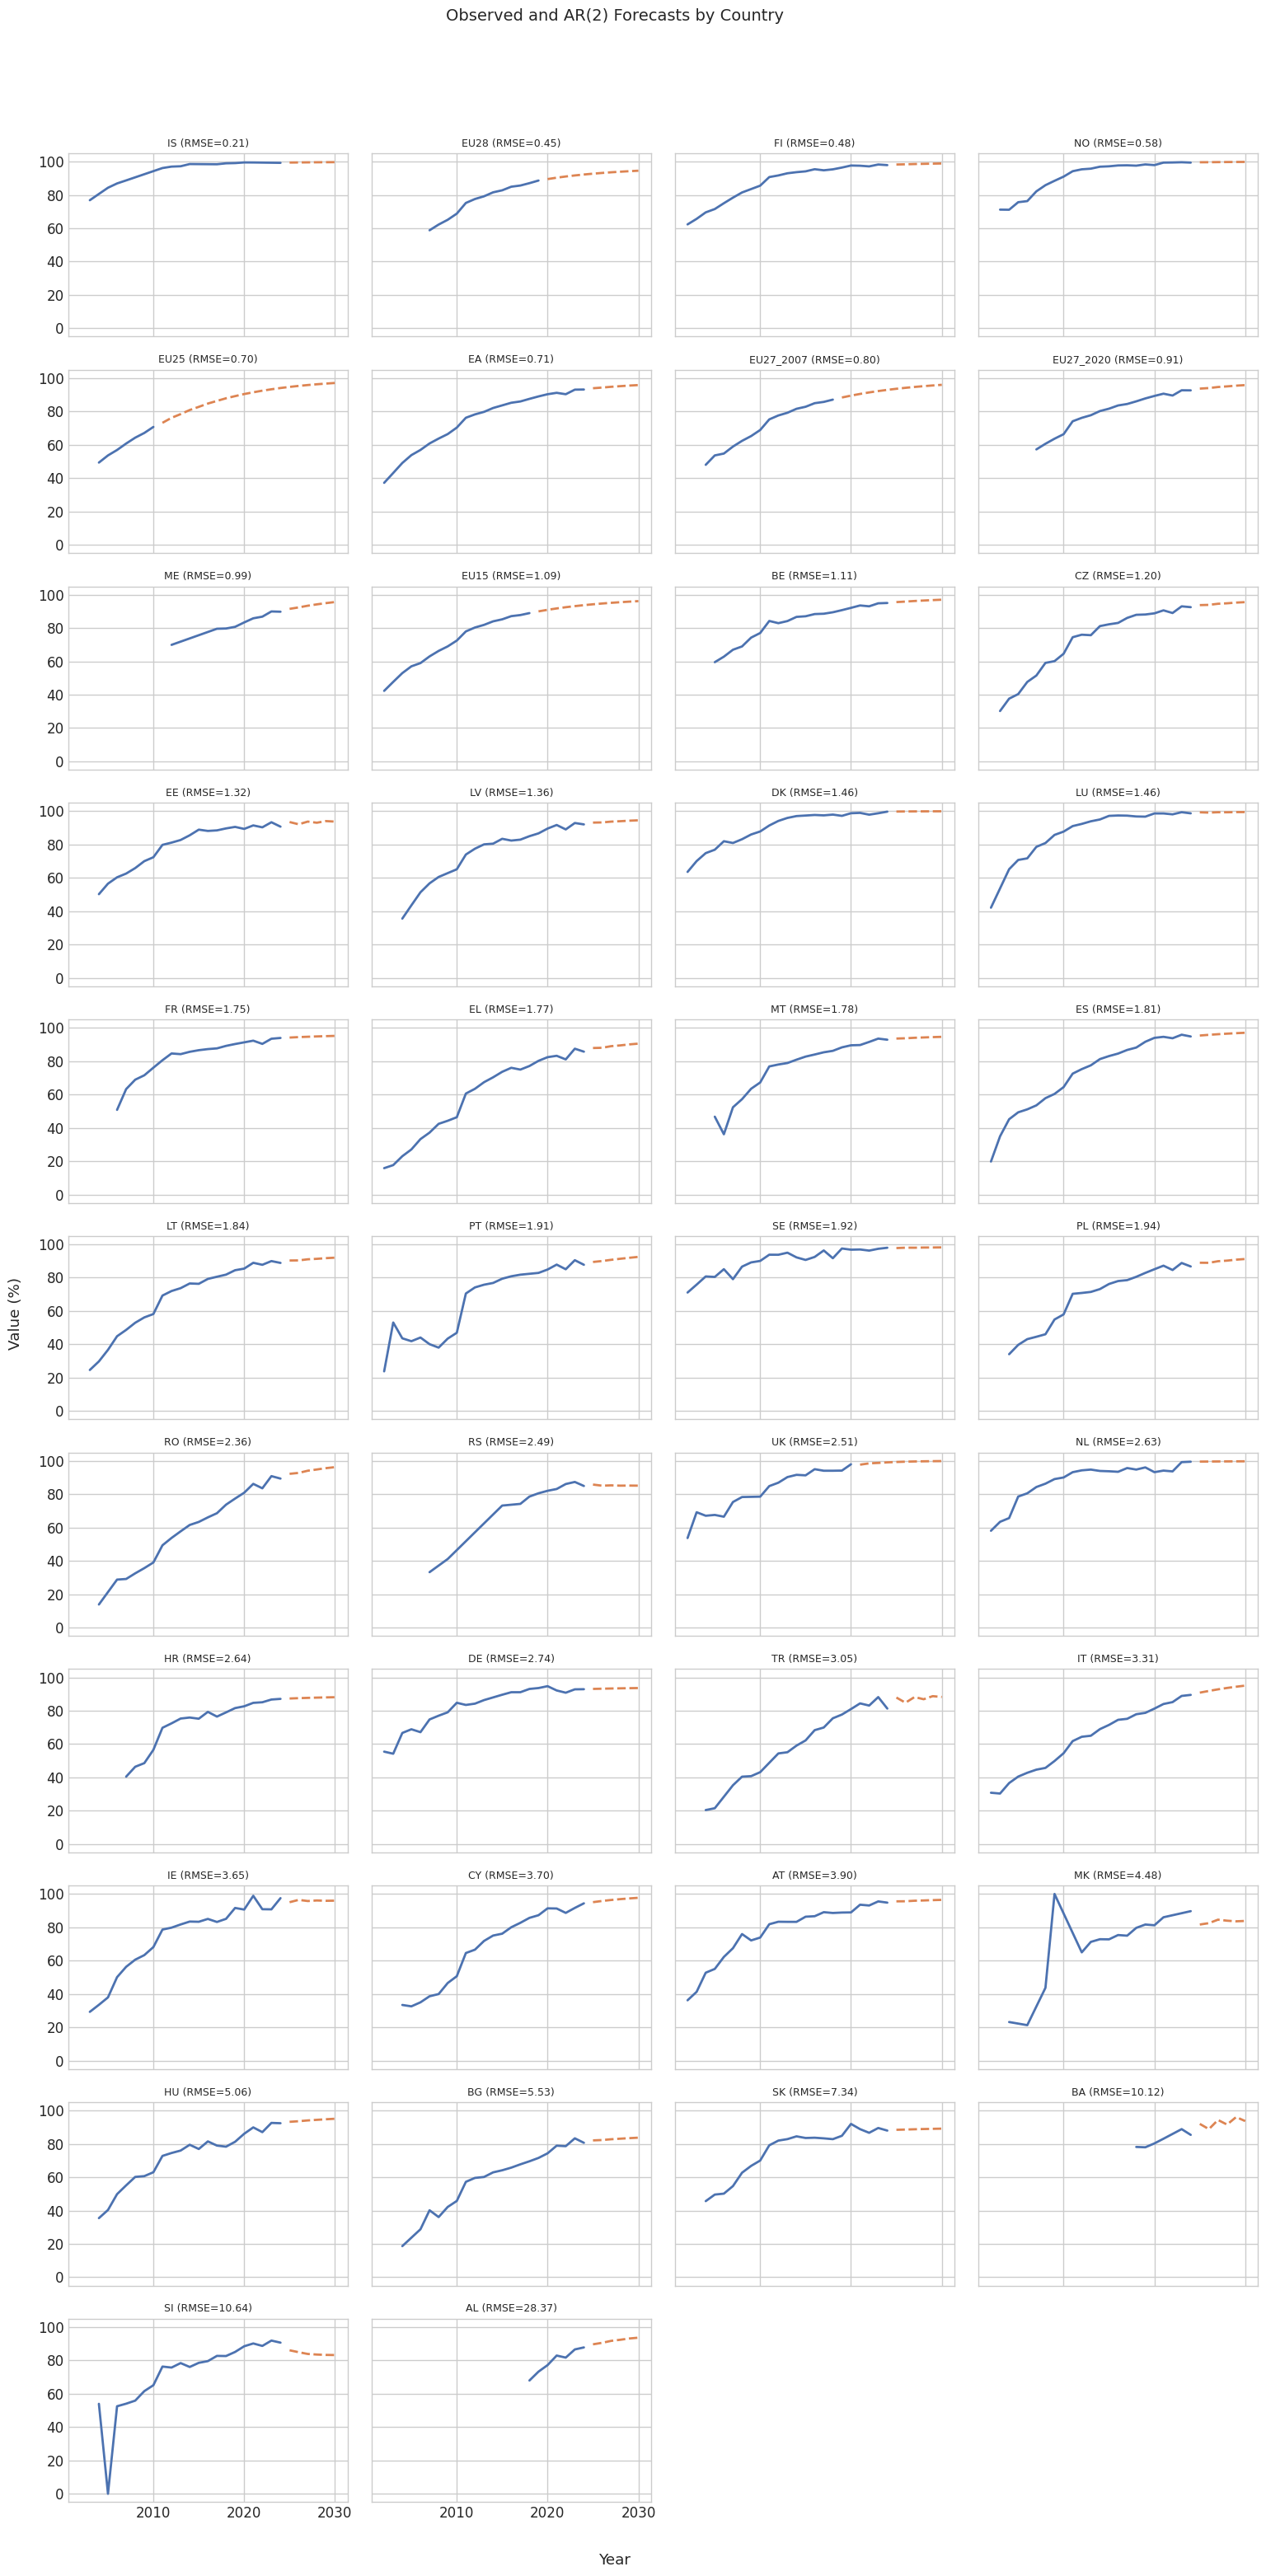

In [63]:
# RMSE per country
per_geo_rmse = (
    eval_df
    .assign(sq_error=(eval_df["y_true"] - eval_df["y_pred"]) ** 2)
    .groupby("geo")["sq_error"]
    .mean()
    .pipe(np.sqrt)
    .sort_values(ascending=True)
)

countries_ordered = per_geo_rmse.index.tolist()

observed_df = (
    df_ar
    .rename(columns={target_col: "y"})
    .assign(type="observed")
    [["geo", "TIME_PERIOD", "y", "type"]]
)

forecast_df = (
    forecast_2030_df
    .rename(columns={"y_pred": "y"})
    .assign(type="forecast")
    [["geo", "TIME_PERIOD", "y", "type"]]
)

full_df = (
    pd.concat([observed_df, forecast_df], ignore_index=True)
    .sort_values(["geo", "TIME_PERIOD"])
)

plot_df = full_df[full_df["geo"].isin(countries_ordered)]

# Plot temporal trend for all countries of use frequency, including forecast
n = len(countries_ordered)
cols = 4                     
rows = math.ceil(n / cols)

fig, axes = plt.subplots(
    rows, cols,
    figsize=(cols * 4, rows * 3),
    sharex=True,
    sharey=True
)

axes = axes.flatten()

for ax, geo in zip(axes, countries_ordered):
    g = plot_df[plot_df["geo"] == geo]

    # observed
    g_obs = g[g["type"] == "observed"]
    ax.plot(
        g_obs["TIME_PERIOD"],
        g_obs["y"],
        linewidth=2
    )

    # forecast
    g_fc = g[g["type"] == "forecast"]
    ax.plot(
        g_fc["TIME_PERIOD"],
        g_fc["y"],
        linestyle="--",
        linewidth=2
    )

    ax.set_title(
        f"{geo} (RMSE={per_geo_rmse[geo]:.2f})",
        fontsize=9
    )
    ax.grid(True)

for ax in axes[len(countries_ordered):]:
    ax.axis("off")

fig.text(0.5, 0.04, "Year", ha="center")
fig.text(0.04, 0.5, "Value (%)", va="center", rotation="vertical")

fig.suptitle(
    "Observed and AR(2) Forecasts by Country",
    fontsize=14
)

fig.tight_layout(rect=[0.05, 0.05, 1, 0.95])
plt.show()

For each country, a line chart showing the observed internet usage frequency and the corresponding predicted values is presented. The plots are ordered by their RMSE in ascending order, so that countries with more accurate predictions appear first. Based on their historical trends, the first countries tend to exhibit increasing future internet usage frequency, while other countries display different patterns, which may lead to a decrease in internet usage frequency (see MK, SI, and RS).

4.2. Q2: Does higher broadband internet coverage speed imply higher frequency of internet usage?
Will be answered for the time range between 2013 and 2024

4.2.1 Pooled OLS
Since the research question focuses on the association between broadband internet availability and internet usage, we refrain from using forecasting models and instead focus on linear modeling approaches. In this context, it is interesting to compare a pooled OLS model with random-effects panel data models. A random-effects model explicitly accounts for country-specific unobserved heterogeneity and therefore helps to reduce inferential bias arising from this structure. Our dataset can be interpreted as a panel dataset, in which countries are the cross-sectional units and time is the indexing dimension. The Breusch-Pagan LM test will be used to assess whether the pooled OLS specification is sufficient or whether a panel-data model is required. The test computes its statistic using the residuals from the pooled OLS regression and examines whether there is a high correlation within units (in this case, countries). In the null hypothesis the variance of the unobserved country-level component is zero. Under this null, the panel structure is irrelevant and the pooled OLS estimator is consistent and efficient. Rejection of the null hypothesis indicates the presence of significant unobserved heterogeneity across countries and therefore supports the use of a random-effects specification over pooled OLS.

**Note**: the category “Missing” is still treated as a distinct category in order to preserve a complete dataset. 

In [64]:
df = filter_reliable_rows(q2_df)
target_col = "I_IU3_all"

categorical_cols = [
    "gender", "age_group", "nativity",
    "nationality", "disability", "education", "hh_income"
]

entity_col = "geo"
time_col = "TIME_PERIOD"
numeric_cols = ["MBPS_GT100", "MBPS_GT2", "MBPS_GT30"]

cols = [entity_col, time_col] + categorical_cols + numeric_cols + [target_col]
df = df[cols].dropna(subset=numeric_cols + [target_col])

df = clean_categoricals(df, categorical_cols)
X = df.drop(columns=[target_col, entity_col, time_col])
y = df[target_col].astype(float)

X_dum = pd.get_dummies(
    X,
    columns=categorical_cols,
    drop_first=True
)

panel_df = (
    pd.concat([X_dum, y], axis=1)
    .replace([np.inf, -np.inf], np.nan)
    .dropna()
    .assign(**{
        entity_col: df.loc[X_dum.index, entity_col].values,
        time_col: df.loc[X_dum.index, time_col].values
    })
    .set_index([entity_col, time_col])
    .sort_index()
)

y_panel = panel_df[target_col].astype(float)
X_panel = panel_df.drop(columns=[target_col]).apply(
    pd.to_numeric, errors="coerce"
)

mask = X_panel.notna().all(axis=1) & y_panel.notna()
X_panel = X_panel.loc[mask]
y_panel = y_panel.loc[mask]

# Constant for pooled OLS / RE
X_panel_const = sm.add_constant(X_panel)

In [65]:
# Pooled OLS
pooled_ols_q2 = PooledOLS(
    y_panel,
    X_panel_const
).fit(
    cov_type="clustered",
    cluster_entity=True
)

In [66]:
def breusch_pagan_lm_test(pooled_ols):
    
    resid = pooled_ols.resids
    T = resid.groupby(level=0).size().mean()
    resid_bar = resid.groupby(level=0).mean()
    
    # LM statistic
    lm_stat = (T / 2) * np.sum(resid_bar**2) / np.var(resid)
    
    # p-value (chi-square with 1 df)
    p_value = 1 - stats.chi2.cdf(lm_stat, df=1)
    
    return lm_stat, p_value

In [67]:
# Breusch–Pagan LM test: if H_0 is rejected, then the random effects model should be chosen
lm_stat, p_value = breusch_pagan_lm_test(pooled_ols_q2)
print("\nBreusch–Pagan LM test (Pooled OLS vs RE)")
print("LM statistic:", lm_stat)
print("p-value:", p_value)


Breusch–Pagan LM test (Pooled OLS vs RE)
LM statistic: 3111.989579756186
p-value: 0.0


The Breusch Pagan test rejects the null hypothesis, concluding that there exist significant effects between countries, which can be captured by the random effects model.

4.2.2 Random Effects Model

In [68]:
# Random Effects
re_model_q2 = RandomEffects(
    y_panel,
    X_panel
).fit(
    cov_type="clustered",
    cluster_entity=True
)
print(re_model_q2.summary)

                        RandomEffects Estimation Summary                        
Dep. Variable:              I_IU3_all   R-squared:                        0.7151
Estimator:              RandomEffects   R-squared (Between):              0.9924
No. Observations:               17552   R-squared (Within):               0.6837
Date:                Wed, Jan 07 2026   R-squared (Overall):              0.9819
Time:                        23:58:46   Log-likelihood                -6.367e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      1466.0
Entities:                          32   P-value                           0.0000
Avg Obs:                       548.50   Distribution:                F(30,17522)
Min Obs:                       214.00                                           
Max Obs:                       614.00   F-statistic (robust):             7847.9
                            

All coefficients of broadband speed coefficients in the random effects model are positive and statistically significant, indicating a robust association between broadband availability and internet usage frequency.

- MBPS_GT2 has the largest coefficient (0.2923, p < 0.001).
This suggests that an increase in the share of connections with speeds above 2 Mbps is associated with a substantial increase in internet usage frequency. Basic broadband availability therefore appears to be a key driver of internet adoption and regular use.

- MBPS_GT30 also shows a strong and highly significant effect (0.1873, p < 0.001).
This indicates that faster broadband connections contribute positively to internet usage, although the marginal effect is smaller than for basic broadband availability.

- MBPS_GT100 has a smaller but still statistically significant coefficient (0.0910, p = 0.0015).
Very high-speed broadband is associated with higher internet usage, but its incremental contribution is more modest, suggesting that ultra-fast connections matter less for general usage frequency than access to reliable baseline speeds.

Overall, the strongest effects arise from expanding basic and intermediate broadband access rather than from ultra-high-speed connections.

4.3. Q3: Does higher internet use frequency imply more mobile broadband internet traffic within or outside of the country?
Will be answered for the time range between 2010 and 2024

In [69]:
# Data Preparation
df = filter_reliable_rows(q3_df)
target_col = "I_IU3_all"

categorical_cols = [
    "gender", "age_group", "nativity",
    "nationality", "disability", "education", "hh_income"
]

entity_col = "geo"
time_col = "TIME_PERIOD"
numeric_cols = ["EB_Total_within", "GB_per_cap_within",	"EB_Total_outside"]
cols = [entity_col, time_col] + categorical_cols + numeric_cols + [target_col]
df = df[cols].dropna(subset=numeric_cols + [target_col])
df = clean_categoricals(df, categorical_cols)
X = df.drop(columns=[target_col, entity_col, time_col])
y = df[target_col].astype(float)

X_dum = pd.get_dummies(
    X,
    columns=categorical_cols,
    drop_first=True
)

panel_df = (
    pd.concat([X_dum, y], axis=1)
    .replace([np.inf, -np.inf], np.nan)
    .dropna()
    .assign(**{
        entity_col: df.loc[X_dum.index, entity_col].values,
        time_col: df.loc[X_dum.index, time_col].values
    })
    .set_index([entity_col, time_col])
    .sort_index()
)

y_panel = panel_df[target_col].astype(float)
X_panel = panel_df.drop(columns=[target_col]).apply(
    pd.to_numeric, errors="coerce"
)

mask = X_panel.notna().all(axis=1) & y_panel.notna()
X_panel = X_panel.loc[mask]
y_panel = y_panel.loc[mask]

# Constant for pooled OLS / RE
X_panel_const = sm.add_constant(X_panel)

In [70]:
pooled_ols_q3 = PooledOLS(
    y_panel,
    X_panel_const
).fit(
    cov_type="clustered",
    cluster_entity=True
)

In [71]:
lm_stat, p_value = breusch_pagan_lm_test(pooled_ols_q3)
print("\nBreusch Pagan LM test (Pooled OLS vs RE)")
print("LM statistic:", lm_stat)
print("p-value:", p_value)


Breusch Pagan LM test (Pooled OLS vs RE)
LM statistic: 3106.172268138673
p-value: 0.0


In [72]:
# Random Effects
re_model_q3 = RandomEffects(
    y_panel,
    X_panel
).fit(
    cov_type="clustered",
    cluster_entity=True
)
print(re_model_q3.summary)

                        RandomEffects Estimation Summary                        
Dep. Variable:              I_IU3_all   R-squared:                        0.9819
Estimator:              RandomEffects   R-squared (Between):              0.9905
No. Observations:               12326   R-squared (Within):               0.6755
Date:                Wed, Jan 07 2026   R-squared (Overall):              0.9819
Time:                        23:58:52   Log-likelihood                -4.788e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                   1.901e+04
Entities:                          24   P-value                           0.0000
Avg Obs:                       513.58   Distribution:                F(35,12291)
Min Obs:                       58.000                                           
Max Obs:                      1000.00   F-statistic (robust):         -7.568e+12
                            

Comments on the random effects model summary:

- Overall R-squared = 0.982 means that the model explains about 98% of total variation in internet usage frequency.

- Between R-squared = 0.991 means that almost all differences across countries are explained by the covariates.

- Within R-squared = 0.676 means that about 68% of within-country changes over time are explained.

- EB_Total_within: when mobile broadband traffic within a country increases over time, internet usage frequency increases significantly (p-value < 0.05).

- EB_Total_outside: mobile broadband traffic outside the country has no statistically association with internet usage frequency.

- GB_per_cap_within: domestic mobile broadband usage growth is strongly associated with higher internet use frequency (p-value < 0.01).